# The necessary libraries imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Reading the Data

In [4]:
dataframe=pd.read_csv("C:/Users/as comp/Downloads/time_series_60min_singleindex.csv")

In [5]:
dataframe.describe()

AT_load_actual_entsoe_transparency  \
count                        50400.000000   
mean                          7070.148631   
std                           1400.263167   
min                            664.000000   
25%                           5941.000000   
50%                           7032.000000   
75%                           8079.000000   
max                          10803.000000   

       AT_load_forecast_entsoe_transparency  AT_price_day_ahead  \
count                          50400.000000        32845.000000   
mean                            7039.848552           33.934663   
std                             1355.382837           14.944863   
min                             3739.000000          -76.000000   
25%                             5941.000000           25.000000   
50%                             7018.000000           33.000000   
75%                             7986.000000           42.000000   
max                            11608.000000          187.000000   

       AT_solar_generation_actual  AT_wind_onshore_generation_actual  \
count                50339.000000                       50352.000000   
mean                   135.280121                         729.653261   
std                    198.955378                         692.002497   
min                      0.000000                           0.000000   
25%                      0.000000                         162.000000   
50%                     18.000000                         493.000000   
75%                    224.000000                        1141.000000   
max                   1166.000000                        2969.000000   

       BE_load_actual_entsoe_transparency  \
count                        50400.000000   
mean                          9808.383929   
std                           1393.548610   
min                           6245.000000   
25%                           8706.000000   
50%                           9809.000000   
75%                          10852.000000   
max                          13670.000000   

       BE_load_forecast_entsoe_transparency  BE_solar_generation_actual  \
count                          50376.000000                50385.000000   
mean                            9759.323567                  393.402158   
std                             1380.214097                  621.803385   
min                             6522.000000                    0.000000   
25%                             8671.000000                    0.000000   
50%                             9757.000000                   10.670000   
75%                            10813.250000                  596.400000   
max                            13454.000000                 3281.400000   

       BE_wind_generation_actual  BE_wind_offshore_generation_actual  ...  \
count               46466.000000                        46466.000000  ...   
mean                  779.920474                          433.482914  ...   
std                   665.931016                          400.823333  ...   
min                     1.090000                            0.000000  ...   
25%                   245.532500                          103.652500  ...   
50%                   571.515000                          317.345000  ...   
75%                  1171.482500                          650.000000  ...   
max                  3252.680000                         1944.160000  ...   

       SE_wind_onshore_capacity  SE_wind_onshore_generation_actual  \
count              43799.000000                       50303.000000   
mean                6297.744058                        2081.680456   
std                  882.140495                        1332.421885   
min                 4767.000000                          18.000000   
25%                 5874.000000                        1048.000000   
50%                 6242.000000                        1834.000000   
75%                 6624.000000                        2832.000000   
max         

In [6]:





# === 2️⃣ Drop unused timestamp ===
df = dataframe.drop(columns=["cet_cest_timestamp"], errors="ignore")

# === 3️⃣ Define main feature patterns ===
features = [
    "load_actual_entsoe_transparency",
    "load_forecast_entsoe_transparency",
    "price_day_ahead",
    "solar_generation_actual",
    "wind_onshore_generation_actual",
    "wind_offshore_generation_actual"
]

# === 4️⃣ Extract country codes dynamically ===
countries = sorted(set([col.split("_")[0] for col in df.columns if "_" in col]))

# === 5️⃣ Build a new dataframe list for all countries ===
dataframes = []

for country in countries:
    cols = [f"{country}_{f}" for f in features if f"{country}_{f}" in df.columns]
    if len(cols) == 0:
        continue  # skip countries missing all features
    
    sub_df = df[["utc_timestamp"] + cols].copy()
    sub_df["country"] = country
    #sub_df['wind_generation'] = sub_df.wind_onshore_generation_actual + sub_df.wind_offshore_generation_actual
    #sub_df.drop(['wind_onshore_generation_actual','wind_offshore_generation_actual'],axis = 1)
    # Rename columns to match desired 5 main features
    rename_map = {f"{country}_{f}": f for f in features if f"{country}_{f}" in sub_df.columns}
    sub_df = sub_df.rename(columns=rename_map)
    
    dataframes.append(sub_df)



# === 6️⃣ Combine all countries vertically ===
final_df = pd.concat(dataframes, ignore_index=True)


final_df['wind_generation'] = final_df.wind_onshore_generation_actual + final_df.wind_offshore_generation_actual
final_df.drop(['wind_onshore_generation_actual','wind_offshore_generation_actual'], axis = 1, inplace = True)

rename_map={"utc_timestamp": "datetime", "load_actual_entsoe_transparency":"load_actual",
    "load_forecast_entsoe_transparency":"load_forecasted",
    "solar_generation_actual":"solar_generation"}

final_df = final_df.rename(columns=rename_map)

#=== 7️⃣ Set datetime as index (optional) ===
#final_df = final_df.rename(columns={"utc_timestamp": "datetime"}).set_index("datetime")

#final_df.describe()
final_df = final_df[['country'] + [col for col in final_df.columns if col != 'country']]

final_df.head()

country              datetime  load_actual  load_forecasted  \
0      AT  2014-12-31T23:00:00Z          NaN              NaN   
1      AT  2015-01-01T00:00:00Z       5946.0           6701.0   
2      AT  2015-01-01T01:00:00Z       5726.0           6593.0   
3      AT  2015-01-01T02:00:00Z       5347.0           6482.0   
4      AT  2015-01-01T03:00:00Z       5249.0           6454.0   

   price_day_ahead  solar_generation  wind_generation  
0              NaN               NaN              NaN  
1             35.0               NaN              NaN  
2             45.0               NaN              NaN  
3             41.0               NaN              NaN  
4             38.0               NaN              NaN

In [74]:
final_df.to_csv("european_load_data.csv")

In [26]:
final_df.to_csv("c:/Users/as comp/Downloads/european_load_data.csv")

In [21]:
#final_df

In [8]:
#final_df.loc[final_df.country=='HR']

In [7]:
#final_df.groupby('country').country.count()


In [10]:
#final_df.groupby('country').apply(lambda df: sns.histplot(df.load_actual_entsoe_transparency,kde=True))

In [11]:
#sns.histplot(final_df[final_df['country'] == 'AT']['load_actual_entsoe_transparency'], kde=True)
#plt.title("Load Distribution for AT")
#plt.xlabel("Load (Actual)")
#plt.ylabel("Frequency")
#plt.show()

In [12]:
#for country in final_df['country'].unique():
#    plt.figure()  # new figure for each country
#    sns.histplot(
#        final_df[final_df['country'] == country]['load_actual_entsoe_transparency'],
#        kde=True
 #   )
#    plt.title(f"Load Distribution for {country}")
#    plt.xlabel("Load (Actual)")
#    plt.ylabel("Frequency")
 #   plt.show()

In [22]:
#final_df.index.dtype

In [23]:
#final_df.index

In [7]:
final_df.datetime=pd.to_datetime(final_df.datetime)

In [8]:
#final_df.index

In [9]:
final_df.datetime.dtype

datetime64[ns, UTC]

In [10]:
for cntry in final_df.country.unique():
    nulls=final_df[final_df.country== cntry].load_actual.isnull().sum()
    print('no. of nulls in {} = {}'.format(cntry, nulls))

no. of nulls in AT = 1
no. of nulls in BE = 1
no. of nulls in BG = 65
no. of nulls in CH = 3
no. of nulls in CY = 17470
no. of nulls in CZ = 110
no. of nulls in DE = 1
no. of nulls in DK = 3
no. of nulls in EE = 83
no. of nulls in ES = 23
no. of nulls in FI = 13
no. of nulls in FR = 44
no. of nulls in GR = 38
no. of nulls in HR = 3
no. of nulls in HU = 1
no. of nulls in IE = 564
no. of nulls in IT = 3
no. of nulls in LT = 194
no. of nulls in LU = 663
no. of nulls in LV = 38
no. of nulls in ME = 739
no. of nulls in NL = 1
no. of nulls in NO = 115
no. of nulls in PL = 3
no. of nulls in PT = 39
no. of nulls in RO = 125
no. of nulls in RS = 784
no. of nulls in SE = 98
no. of nulls in SI = 61
no. of nulls in SK = 28


In [11]:
for cntry in final_df.country.unique():
    nulls=final_df[final_df.country== cntry].load_forecasted.isnull().sum()
    print('no. of nulls in {} = {}'.format(cntry, nulls))

no. of nulls in AT = 1
no. of nulls in BE = 25
no. of nulls in BG = 3696
no. of nulls in CH = 75
no. of nulls in CY = 29048
no. of nulls in CZ = 51
no. of nulls in DE = 25
no. of nulls in DK = 3
no. of nulls in EE = 449
no. of nulls in ES = 3
no. of nulls in FI = 75
no. of nulls in FR = 3
no. of nulls in GR = 3
no. of nulls in HR = 27
no. of nulls in HU = 48
no. of nulls in IE = 480
no. of nulls in IT = 27
no. of nulls in LT = 732
no. of nulls in LU = 1105
no. of nulls in LV = 194
no. of nulls in ME = 314
no. of nulls in NL = 1
no. of nulls in NO = 27
no. of nulls in PL = 50
no. of nulls in PT = 4
no. of nulls in RO = 121
no. of nulls in RS = 964
no. of nulls in SE = 147
no. of nulls in SI = 3
no. of nulls in SK = 3


In [12]:
for cntry in final_df.country.unique():
    nulls=final_df[final_df.country== cntry].solar_generation.isnull().sum()
    print('no. of nulls in {} = {}'.format(cntry, nulls))

no. of nulls in AT = 62
no. of nulls in BE = 16
no. of nulls in BG = 17
no. of nulls in CH = 56
no. of nulls in CY = 50401
no. of nulls in CZ = 36
no. of nulls in DE = 104
no. of nulls in DK = 12
no. of nulls in EE = 87
no. of nulls in ES = 17
no. of nulls in FI = 50401
no. of nulls in FR = 15
no. of nulls in GR = 48
no. of nulls in HR = 50391
no. of nulls in HU = 41436
no. of nulls in IE = 50401
no. of nulls in IT = 6600
no. of nulls in LT = 834
no. of nulls in LU = 50401
no. of nulls in LV = 50401
no. of nulls in ME = 50401
no. of nulls in NL = 5055
no. of nulls in NO = 50401
no. of nulls in PL = 46237
no. of nulls in PT = 46
no. of nulls in RO = 132
no. of nulls in RS = 50401
no. of nulls in SE = 50401
no. of nulls in SI = 10
no. of nulls in SK = 391


In [21]:
#for cntry in final_df.country.unique():
#    nulls=final_df[final_df.country== cntry].wind_onshore_generation_actual.isnull().sum()
#    print('no. of nulls in {} = {}'.format(cntry, nulls))

In [13]:
final_df.loc[(final_df.datetime.dt.hour <= 6) | (final_df.datetime.dt.hour >= 18), 'solar_generation'] = 0

In [14]:
for cntry in final_df.country.unique():
    nulls=final_df[final_df.country== cntry].solar_generation.isnull().sum()
    print('no. of nulls in {} = {}'.format(cntry, nulls))

no. of nulls in AT = 22
no. of nulls in BE = 2
no. of nulls in BG = 3
no. of nulls in CH = 23
no. of nulls in CY = 23100
no. of nulls in CZ = 10
no. of nulls in DE = 44
no. of nulls in DK = 1
no. of nulls in EE = 32
no. of nulls in ES = 9
no. of nulls in FI = 23100
no. of nulls in FR = 1
no. of nulls in GR = 7
no. of nulls in HR = 23091
no. of nulls in HU = 18987
no. of nulls in IE = 23100
no. of nulls in IT = 3020
no. of nulls in LT = 359
no. of nulls in LU = 23100
no. of nulls in LV = 23100
no. of nulls in ME = 23100
no. of nulls in NL = 2311
no. of nulls in NO = 23100
no. of nulls in PL = 21188
no. of nulls in PT = 19
no. of nulls in RO = 53
no. of nulls in RS = 23100
no. of nulls in SE = 23100
no. of nulls in SI = 1
no. of nulls in SK = 169


In [60]:
#null_index = final_df.index[(final_df.country=='BG') & (final_df['load_actual_entsoe_transparency'].isnull())].tolist()


In [140]:
#null_index_CZ

In [16]:
#null_index_EE = final_df.index[(final_df.country=='EE') & (final_df['load_actual_entsoe_transparency'].isnull())].tolist()


In [44]:
load_series_df = final_df[['country','load_actual']]

In [45]:

load_series_df.set_index(final_df.datetime)


country  load_actual
datetime                                      
2014-12-31 23:00:00+00:00      AT          NaN
2015-01-01 00:00:00+00:00      AT       5946.0
2015-01-01 01:00:00+00:00      AT       5726.0
2015-01-01 02:00:00+00:00      AT       5347.0
2015-01-01 03:00:00+00:00      AT       5249.0
...                           ...          ...
2020-09-30 19:00:00+00:00      SK       3324.0
2020-09-30 20:00:00+00:00      SK       3099.0
2020-09-30 21:00:00+00:00      SK       2940.0
2020-09-30 22:00:00+00:00      SK       2823.0
2020-09-30 23:00:00+00:00      SK          NaN

[1512030 rows x 2 columns]

C:\Users\as comp\AppData\Local\Temp\ipykernel_14376\4223326908.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


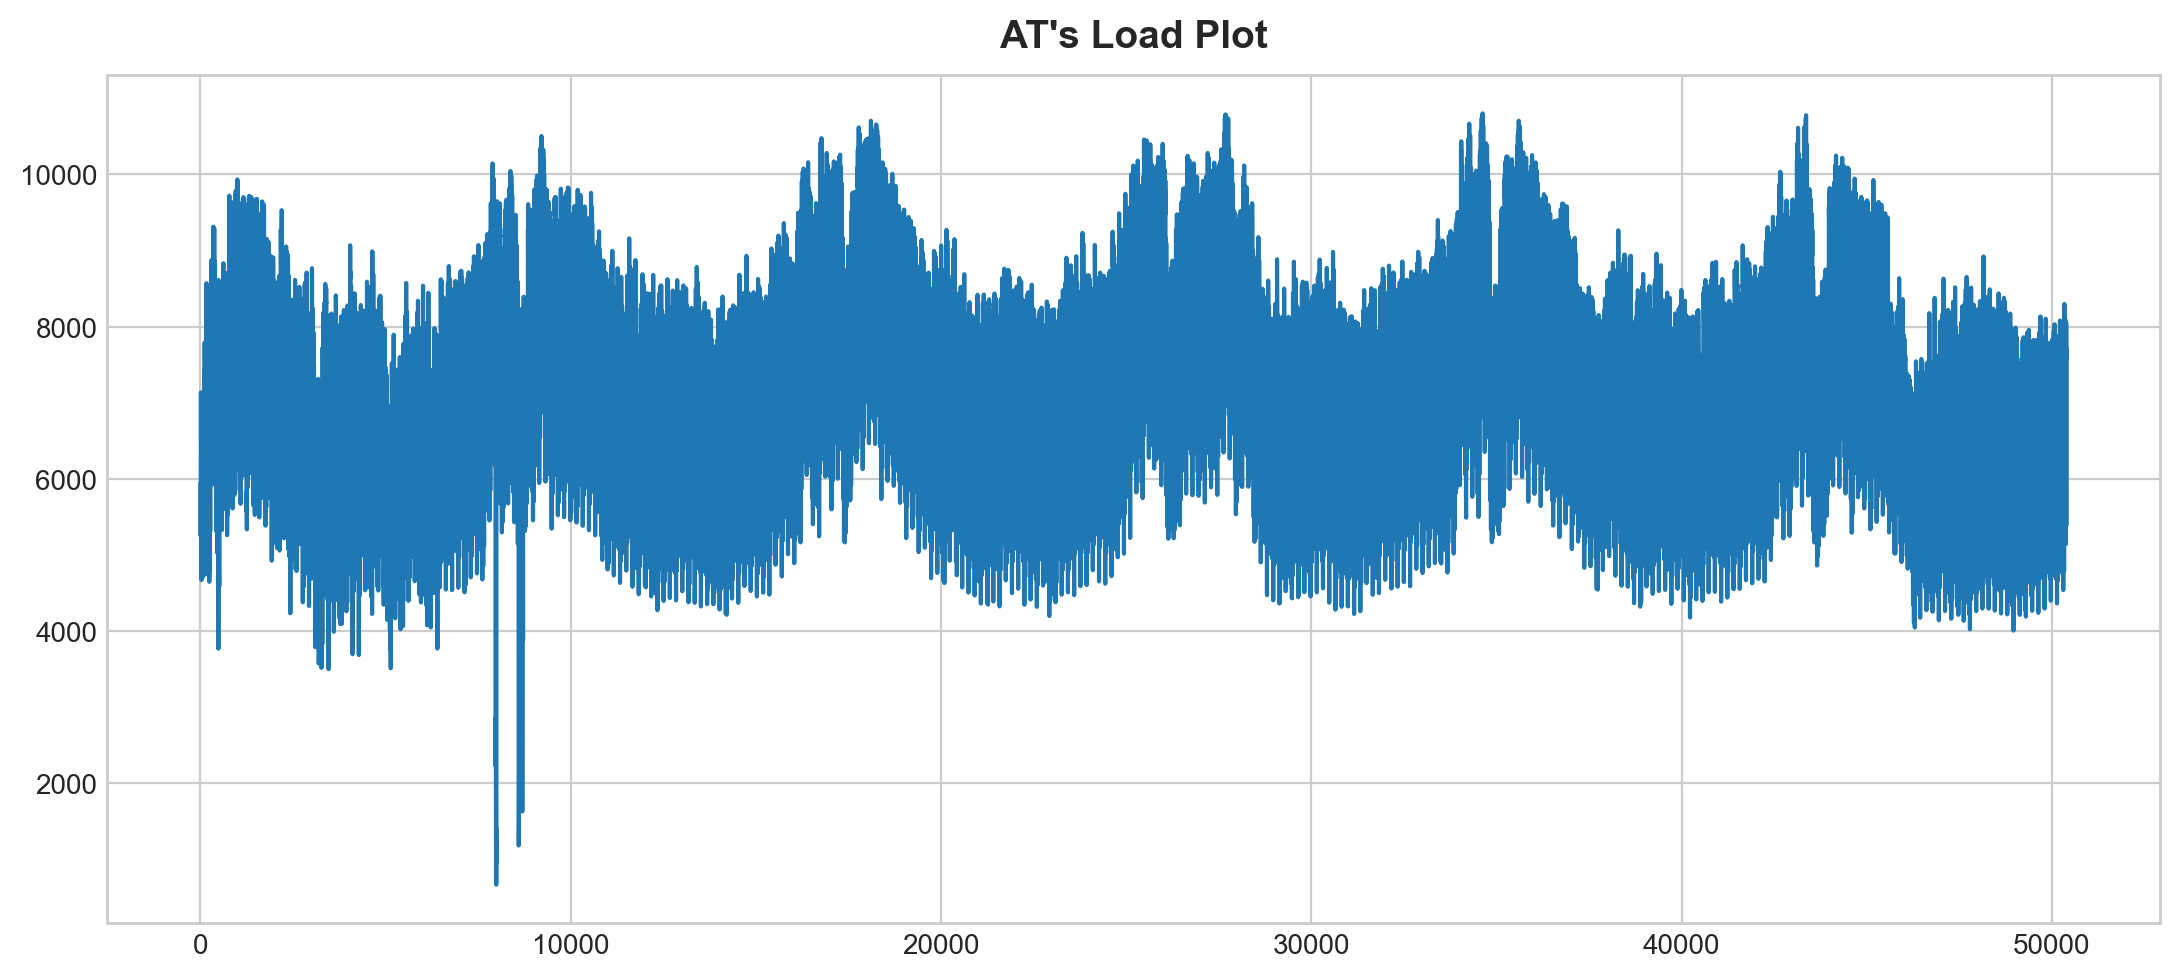

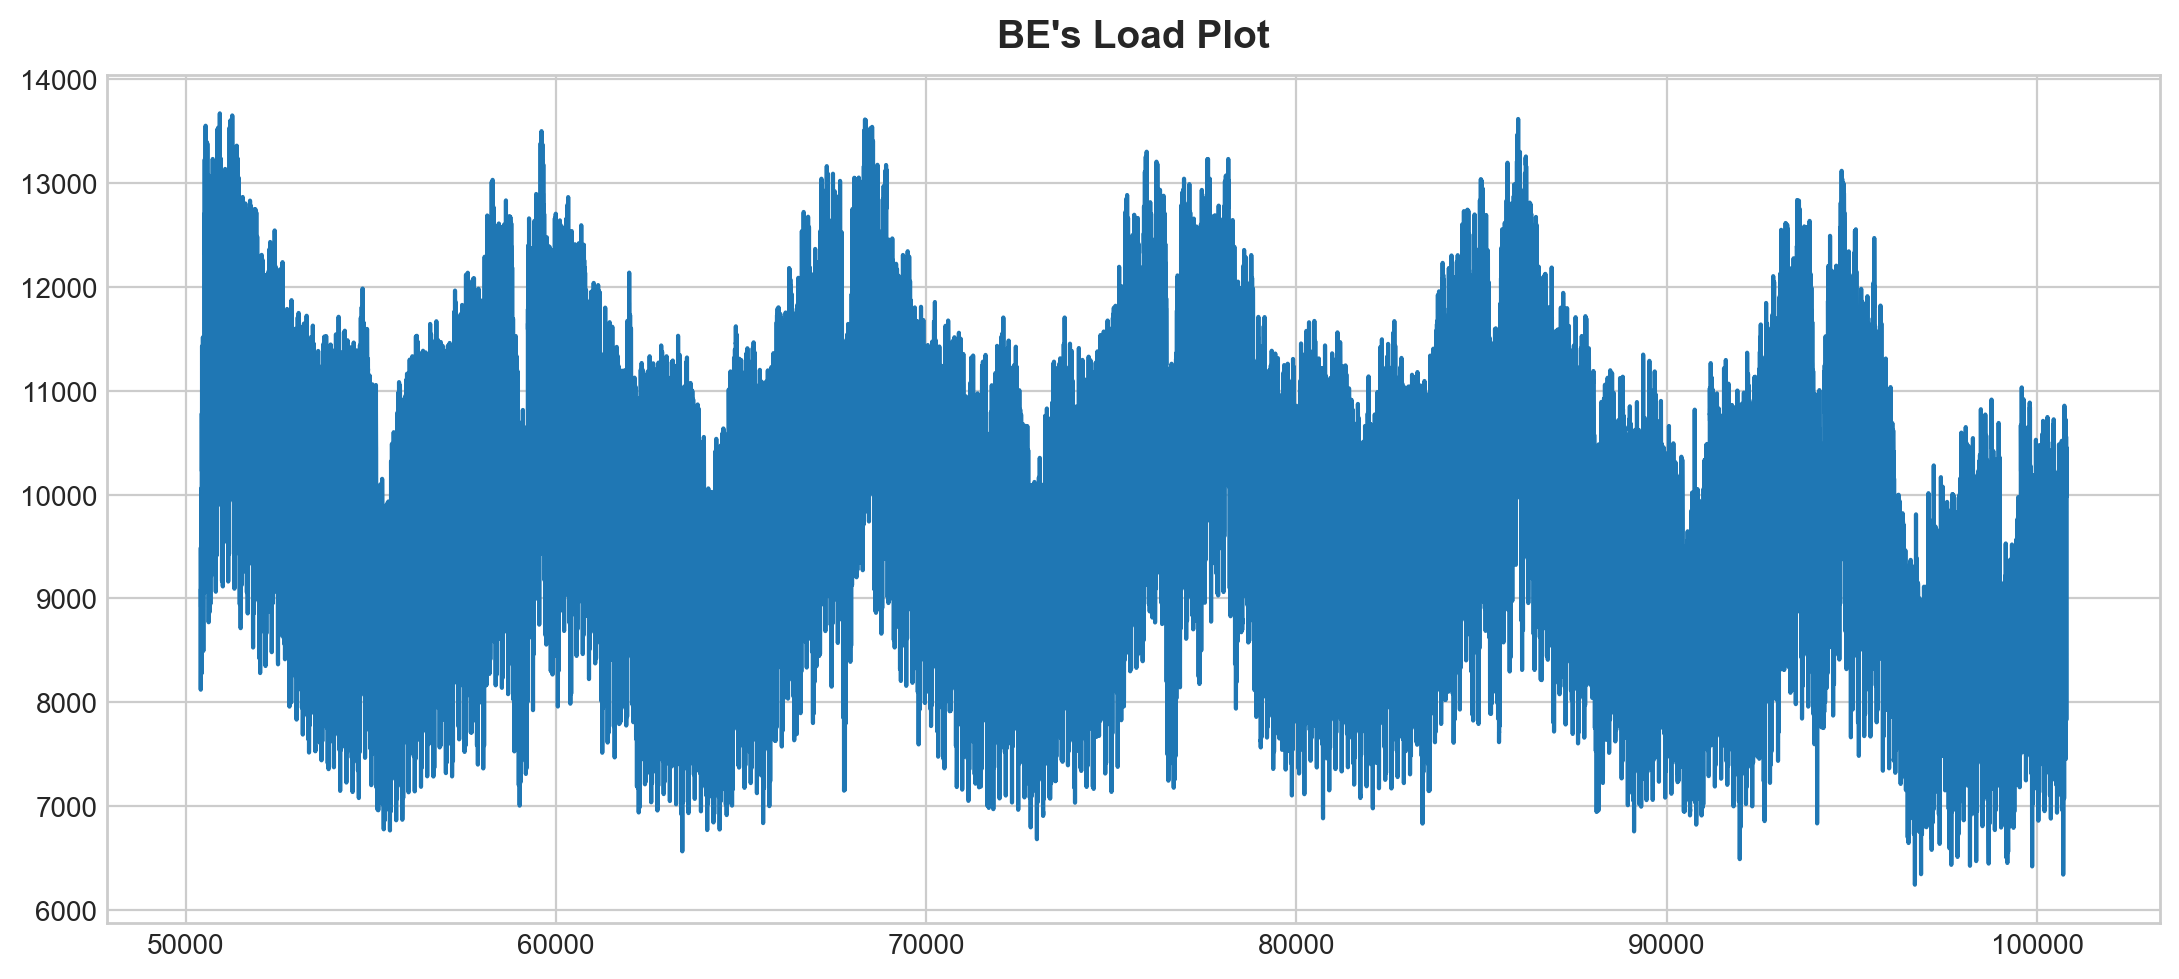

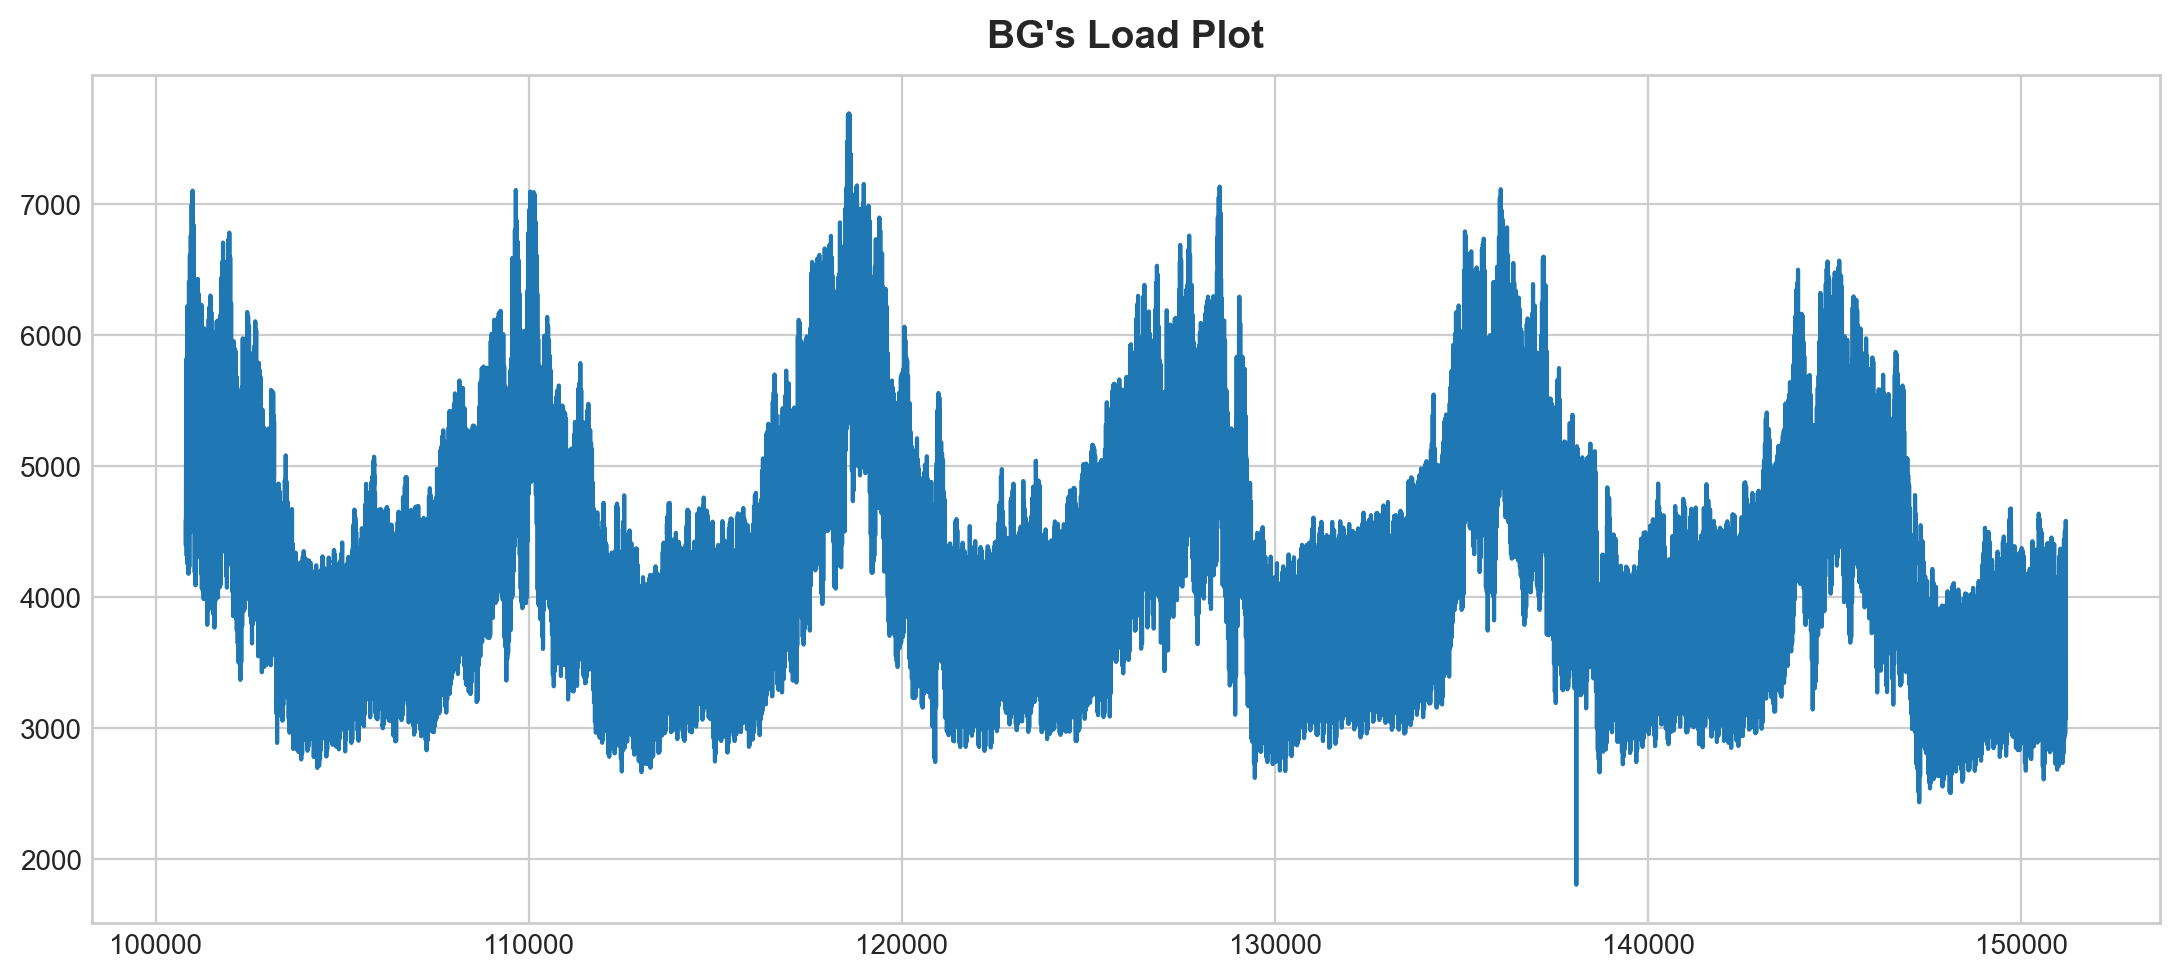

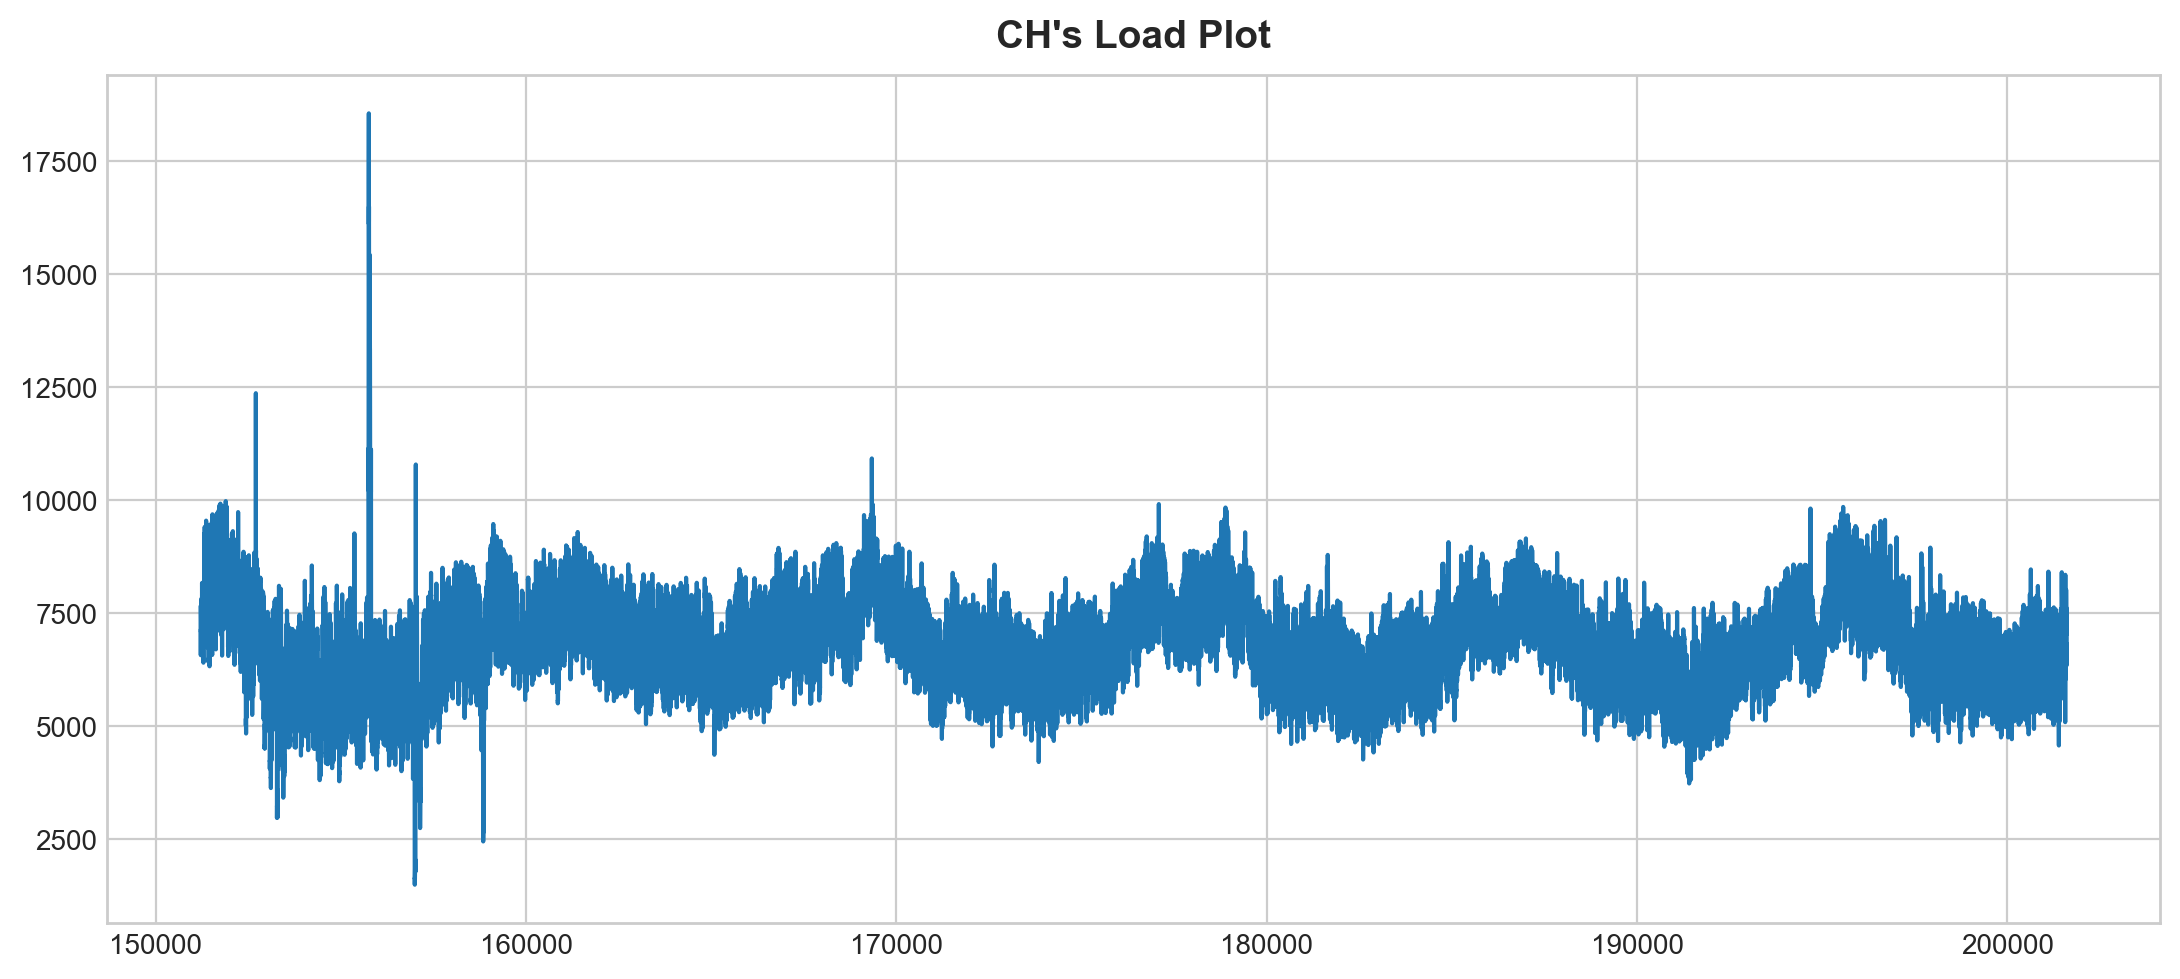

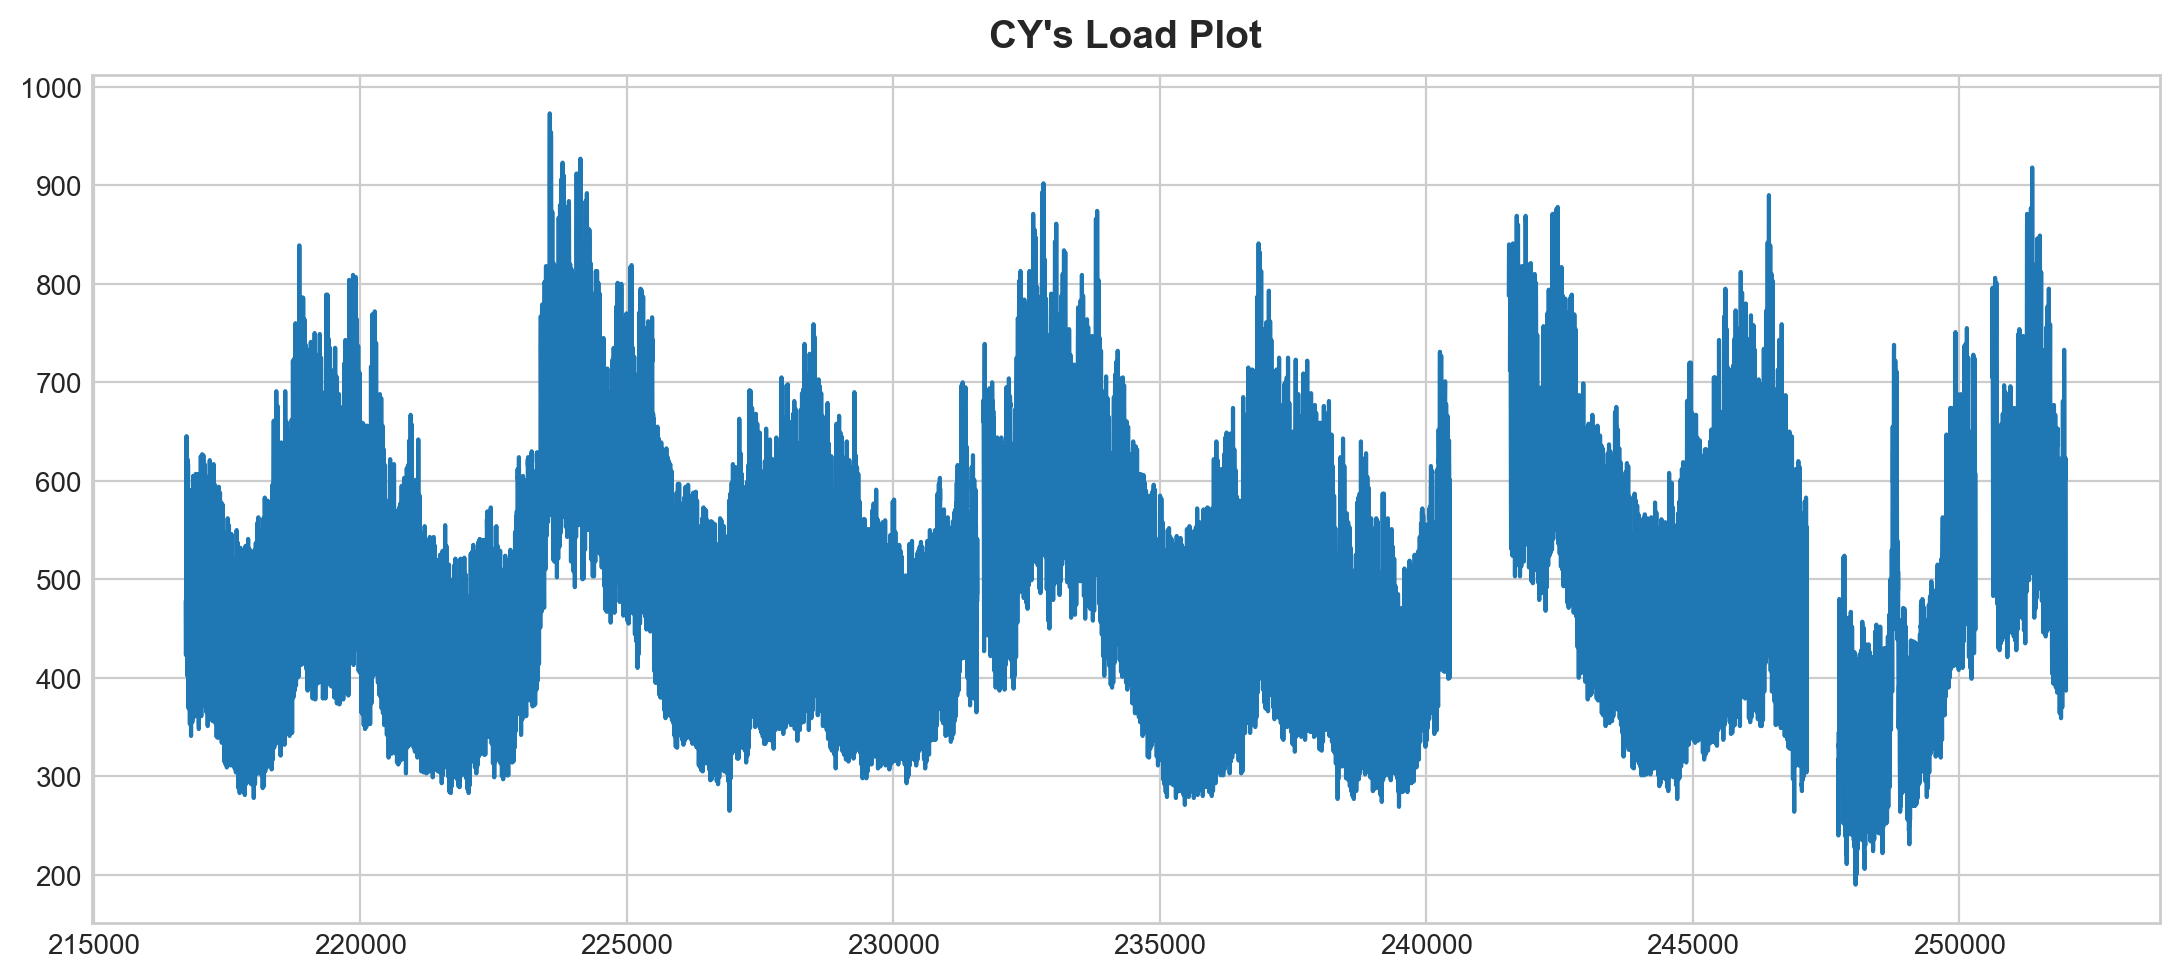

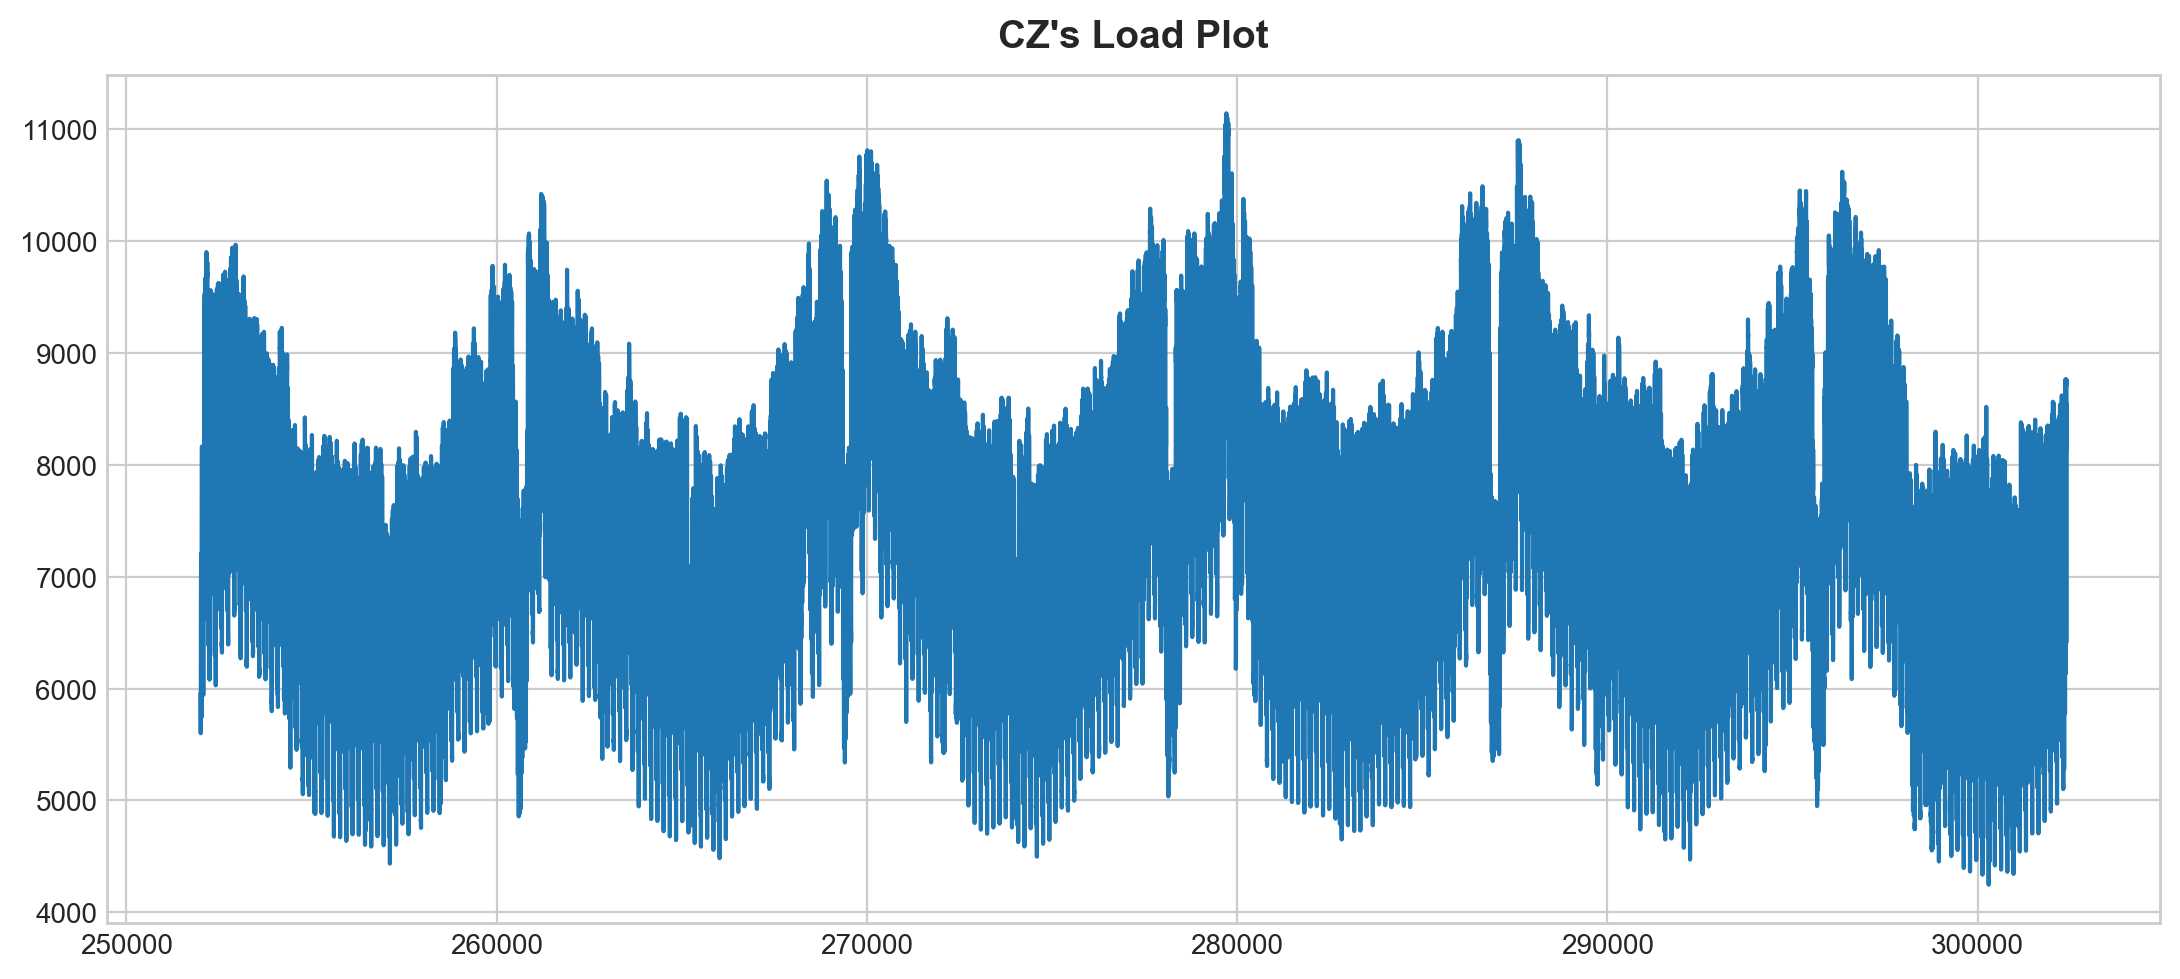

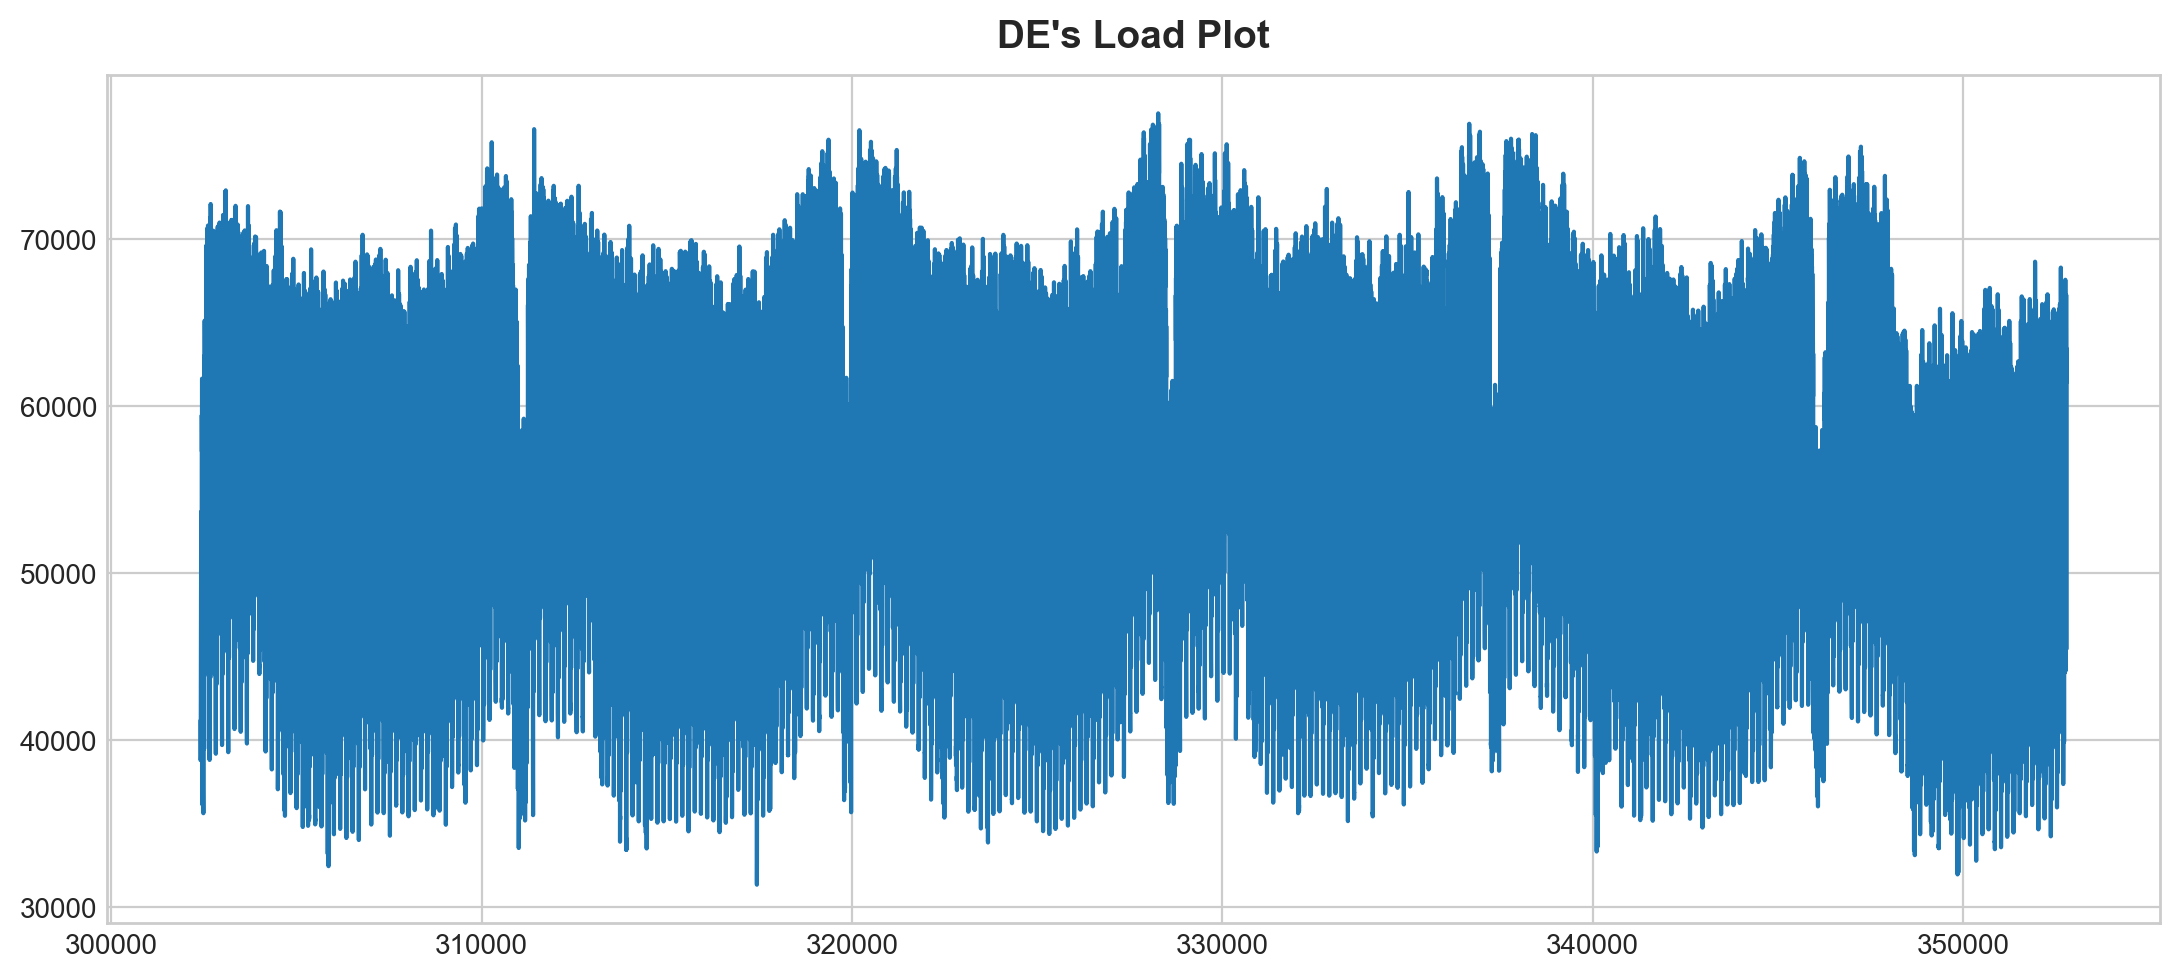

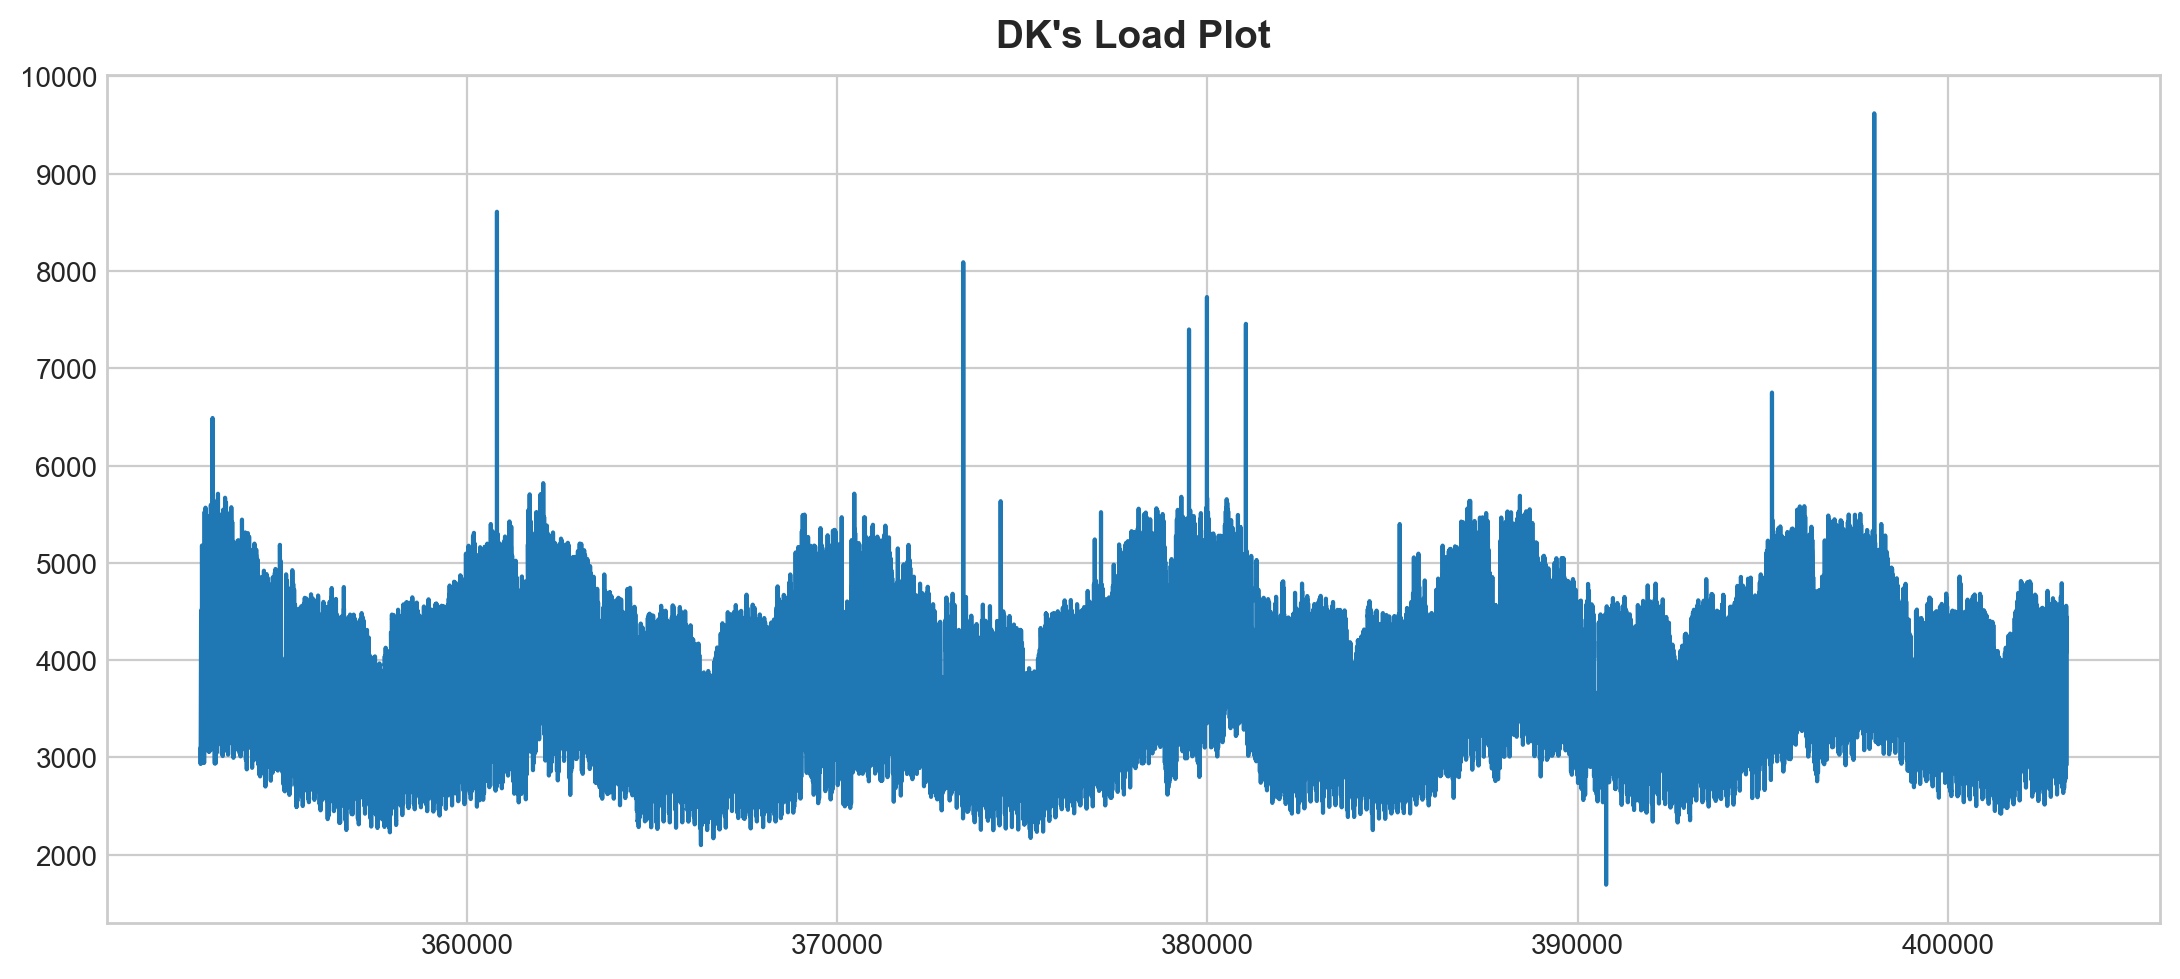

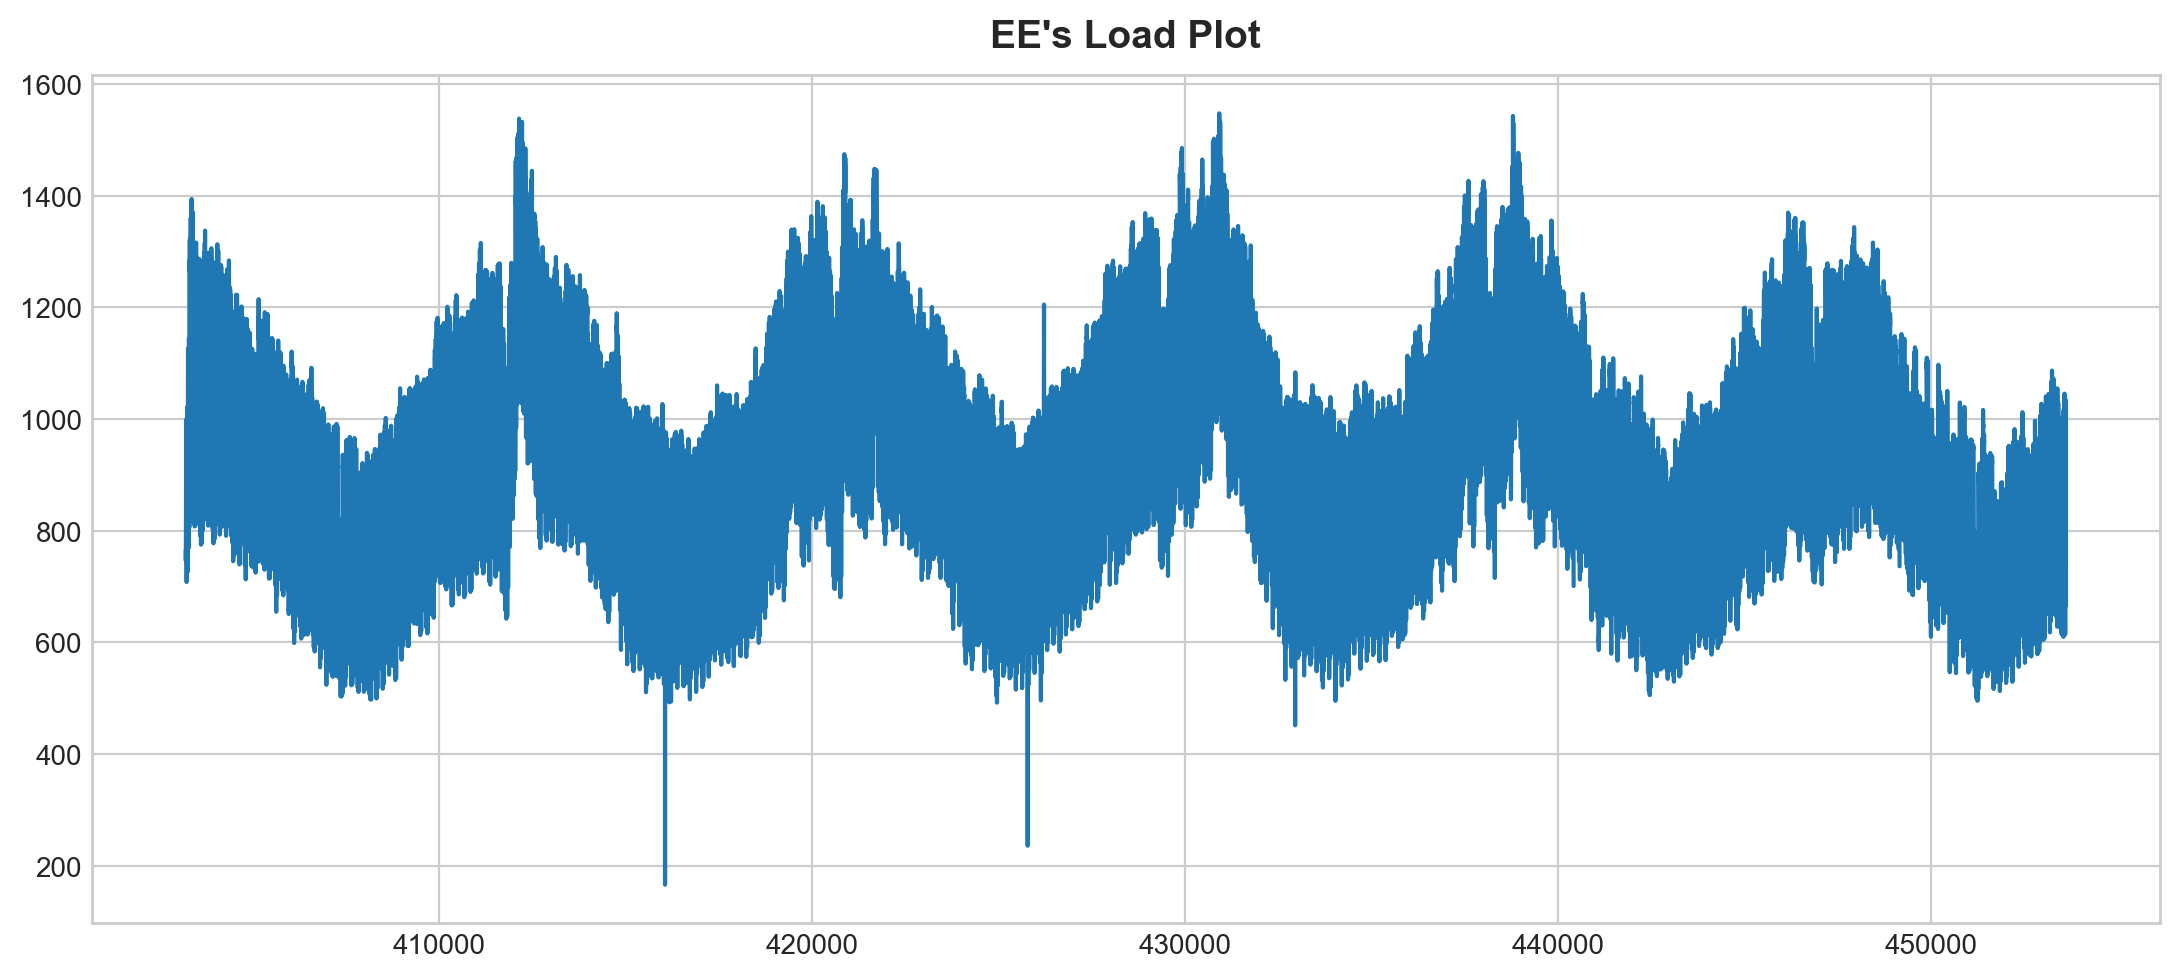

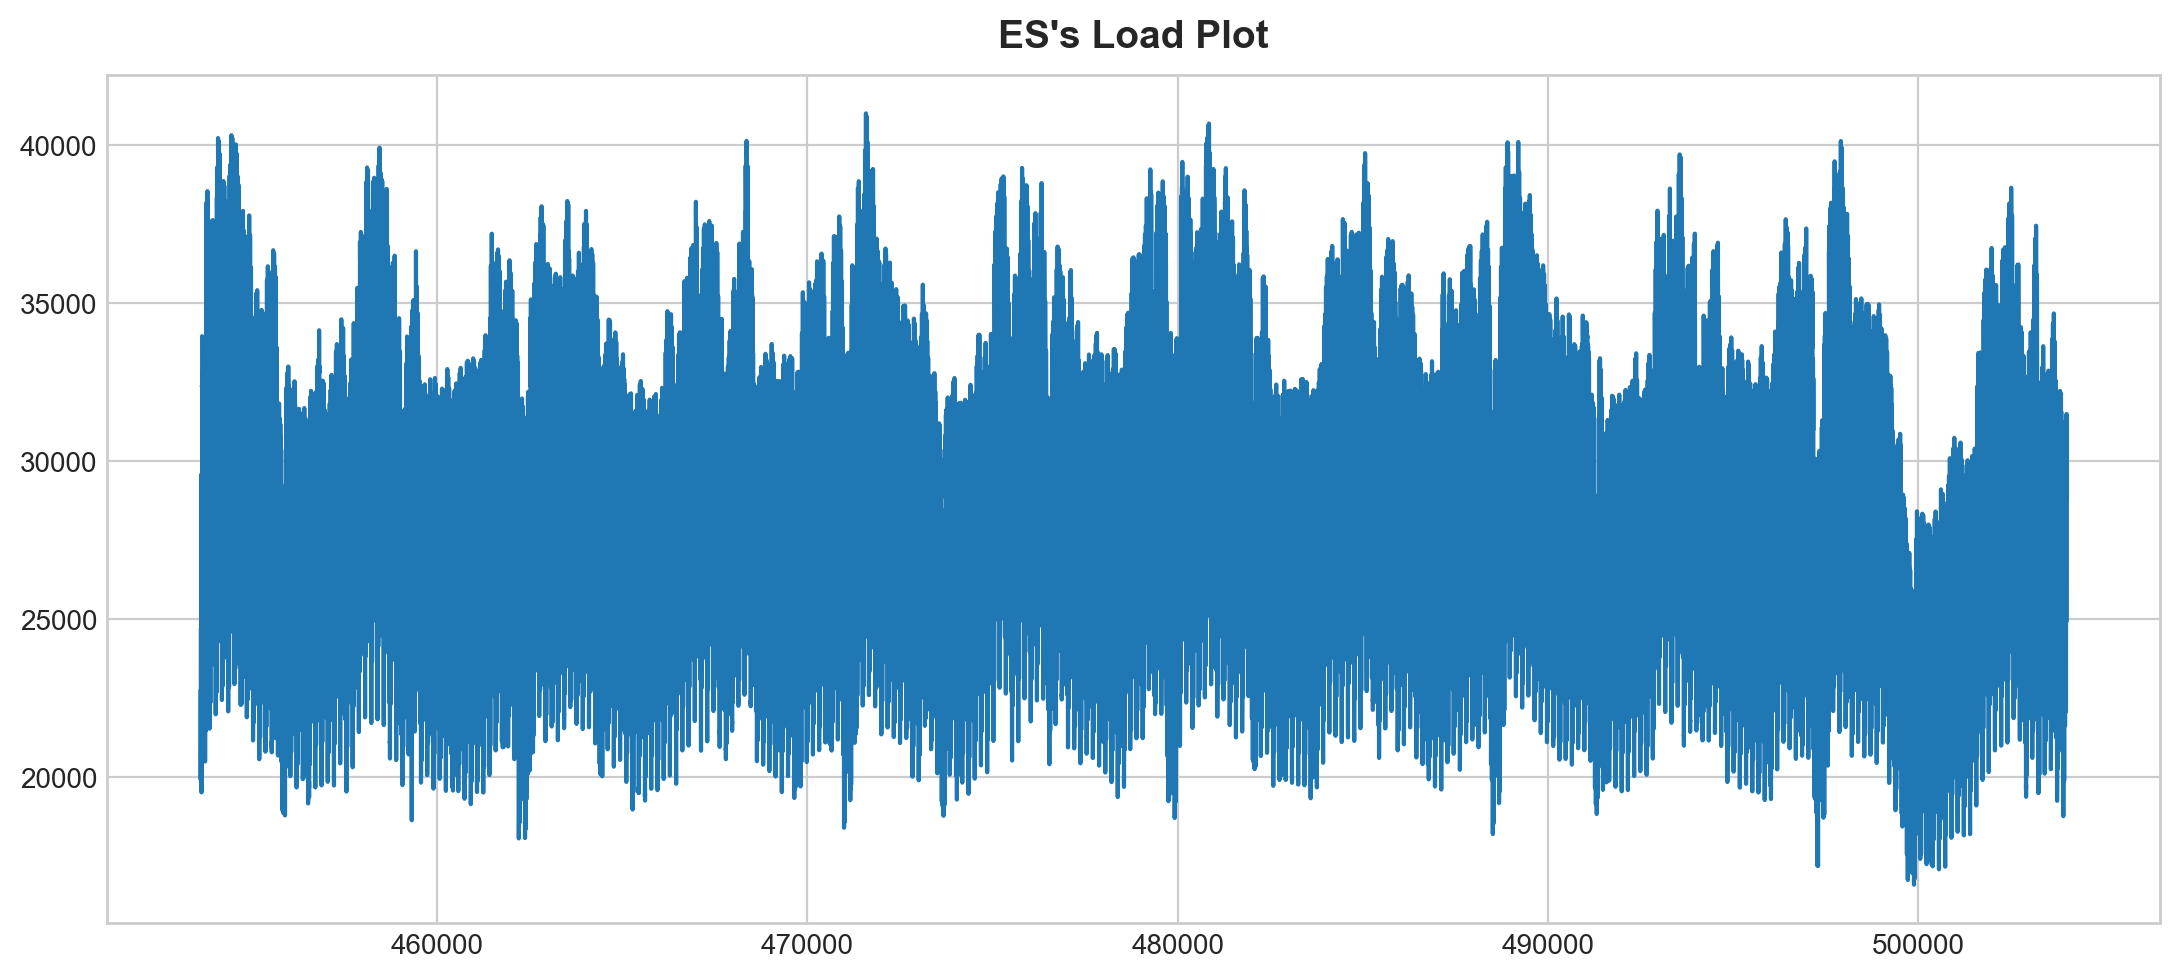

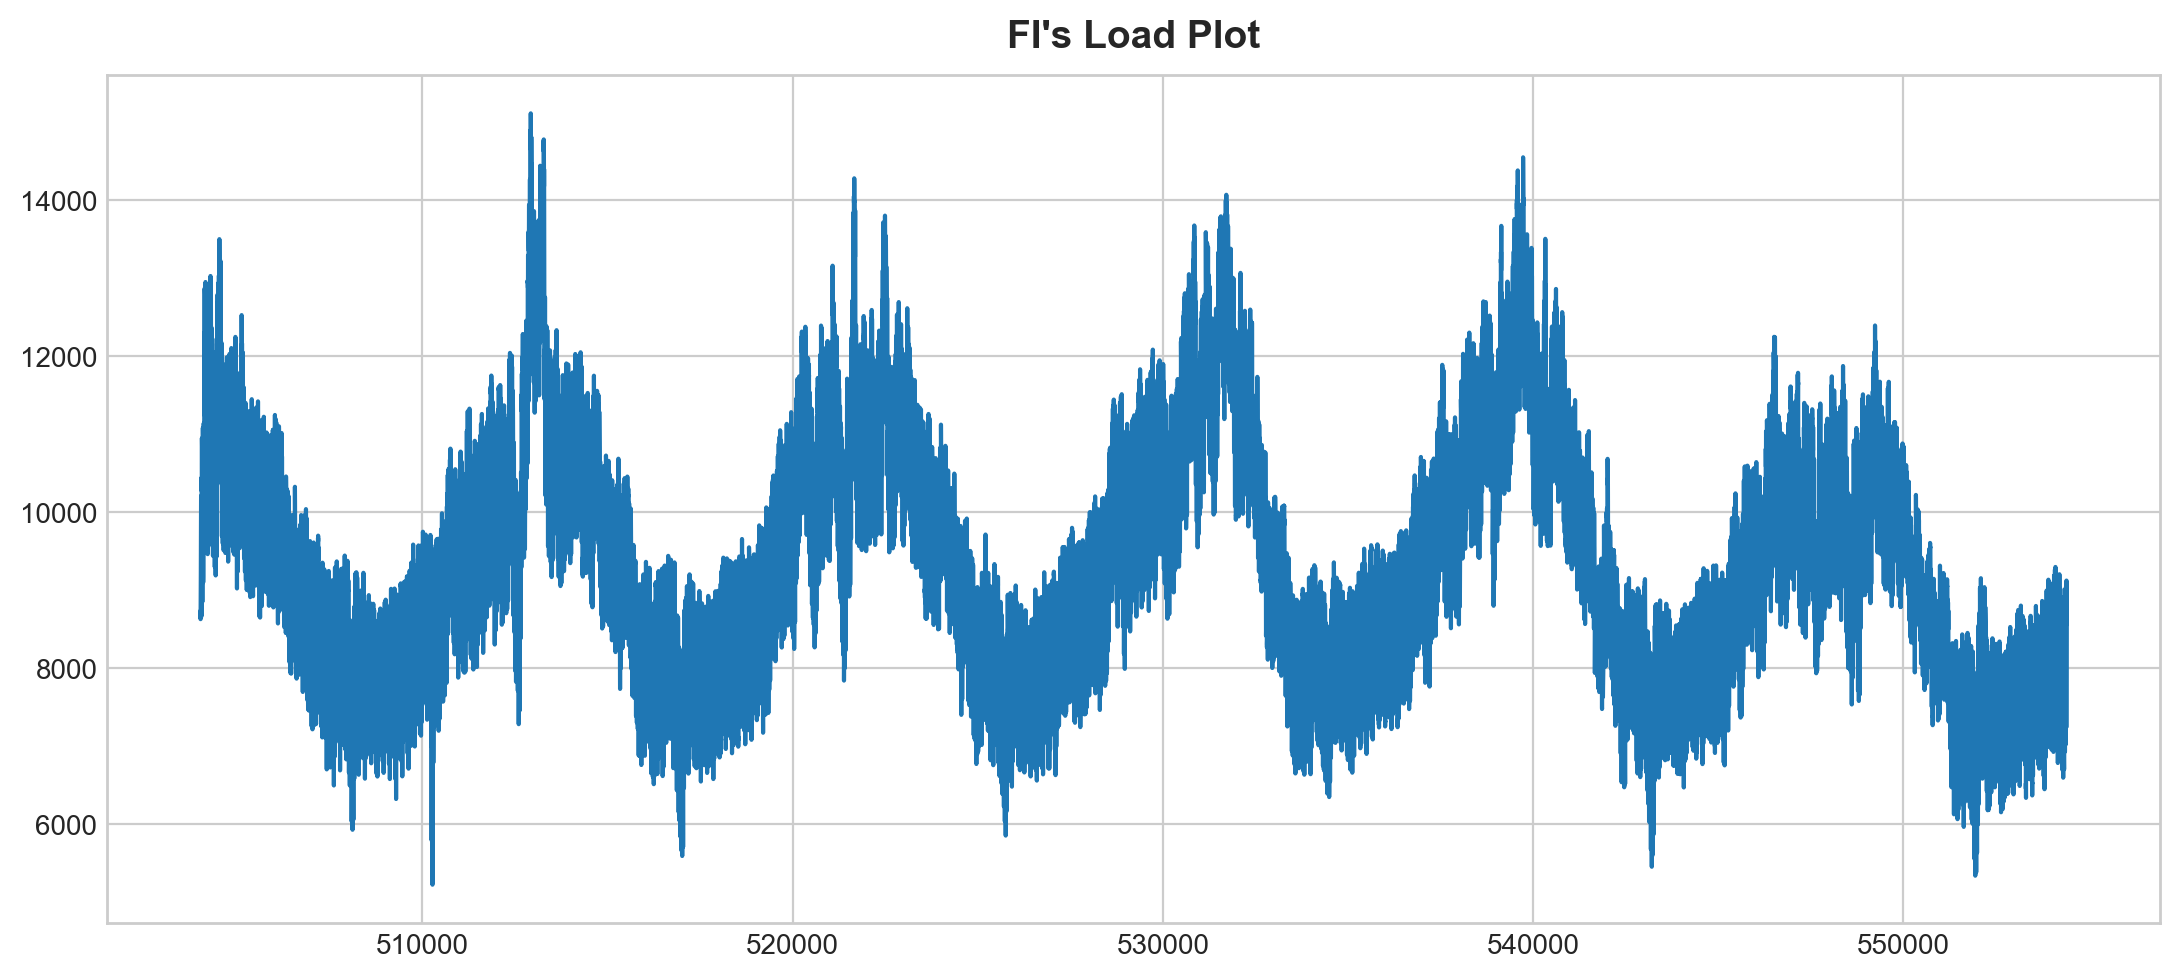

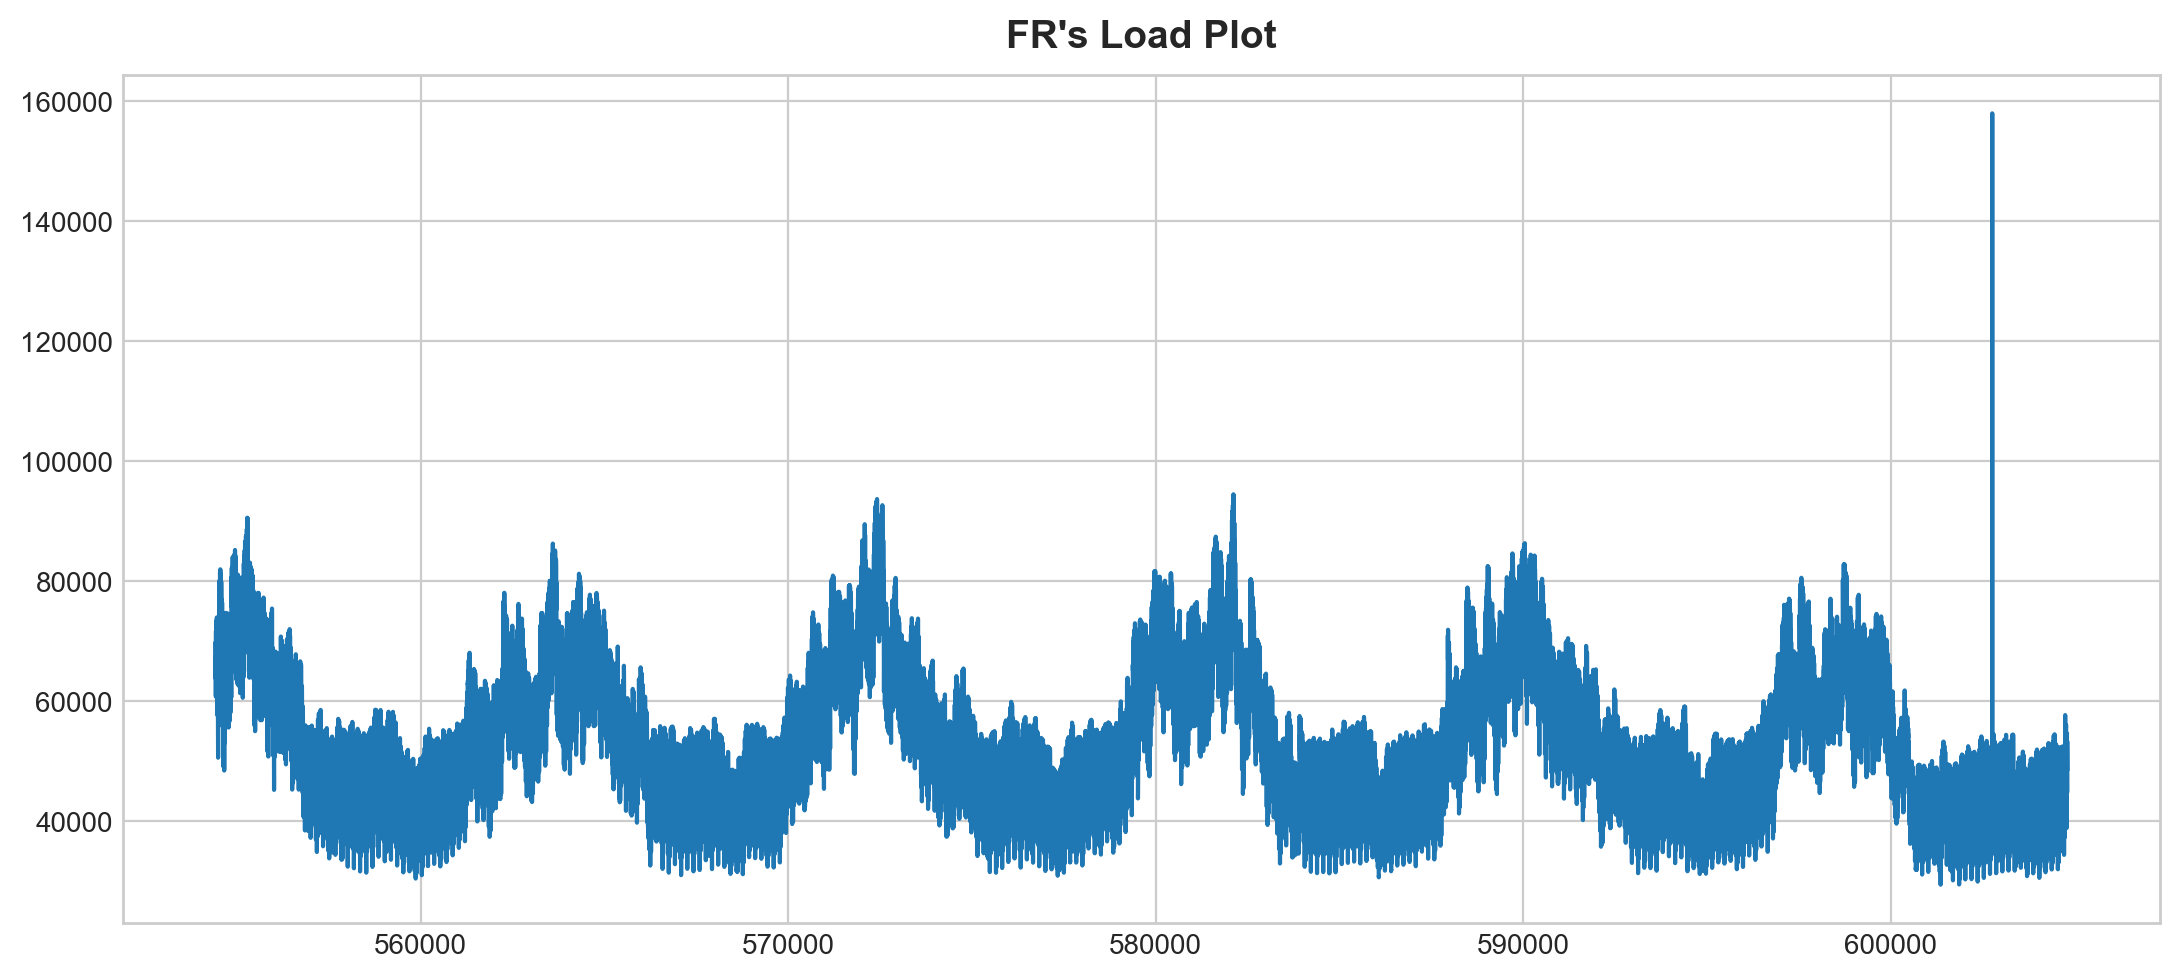

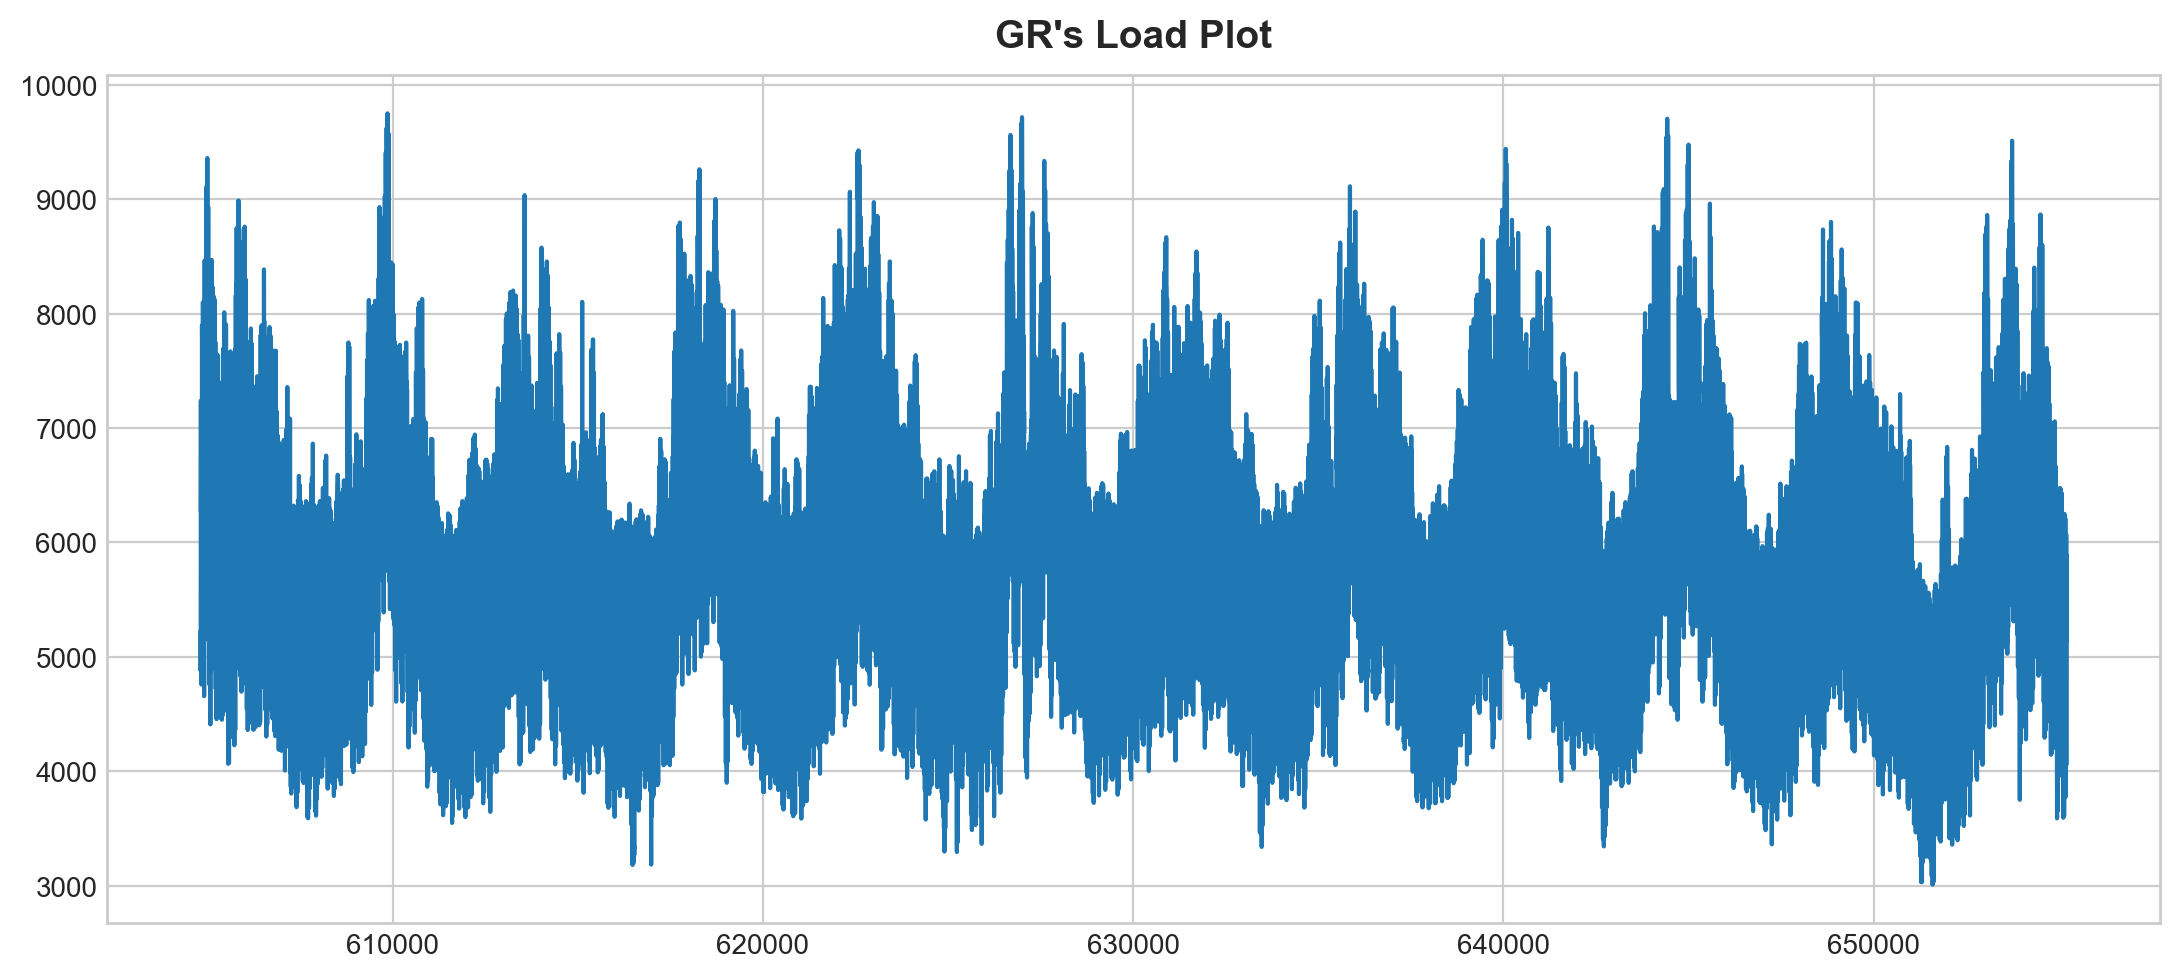

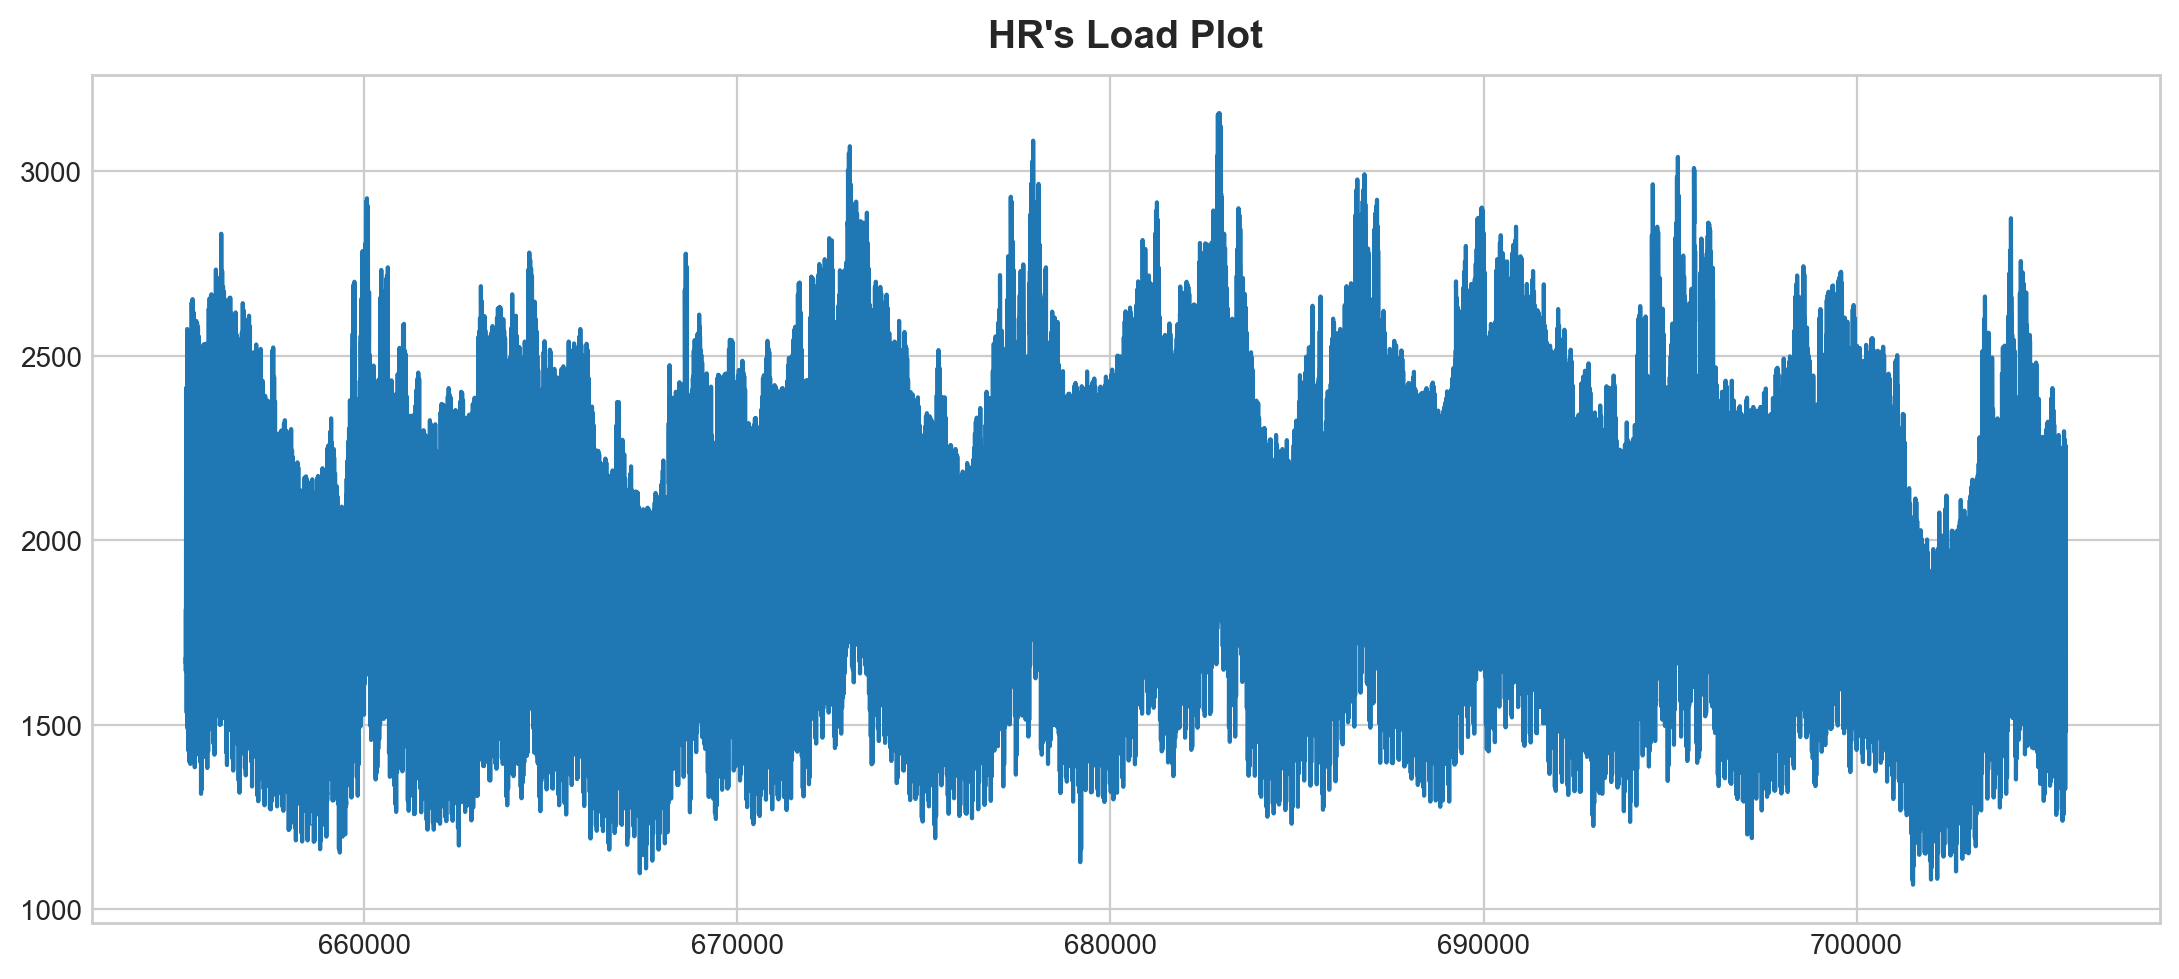

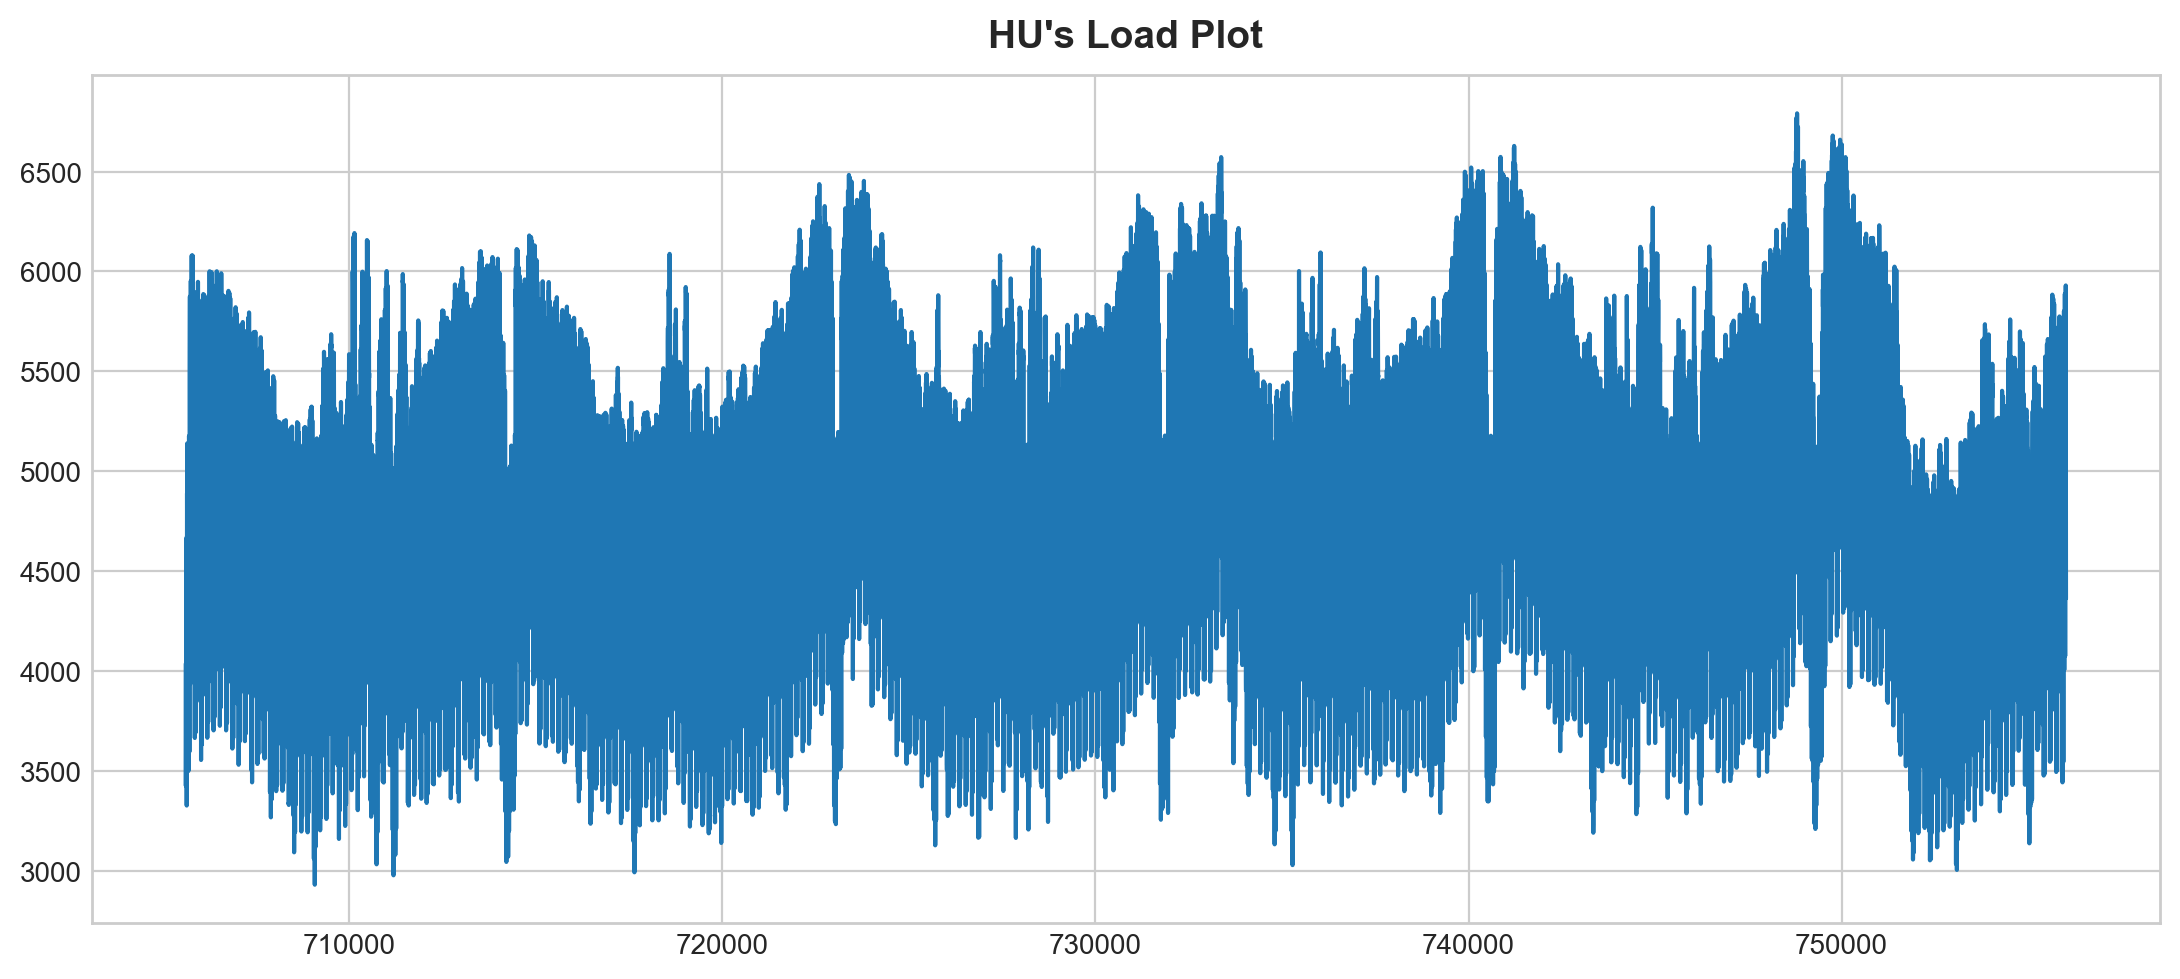

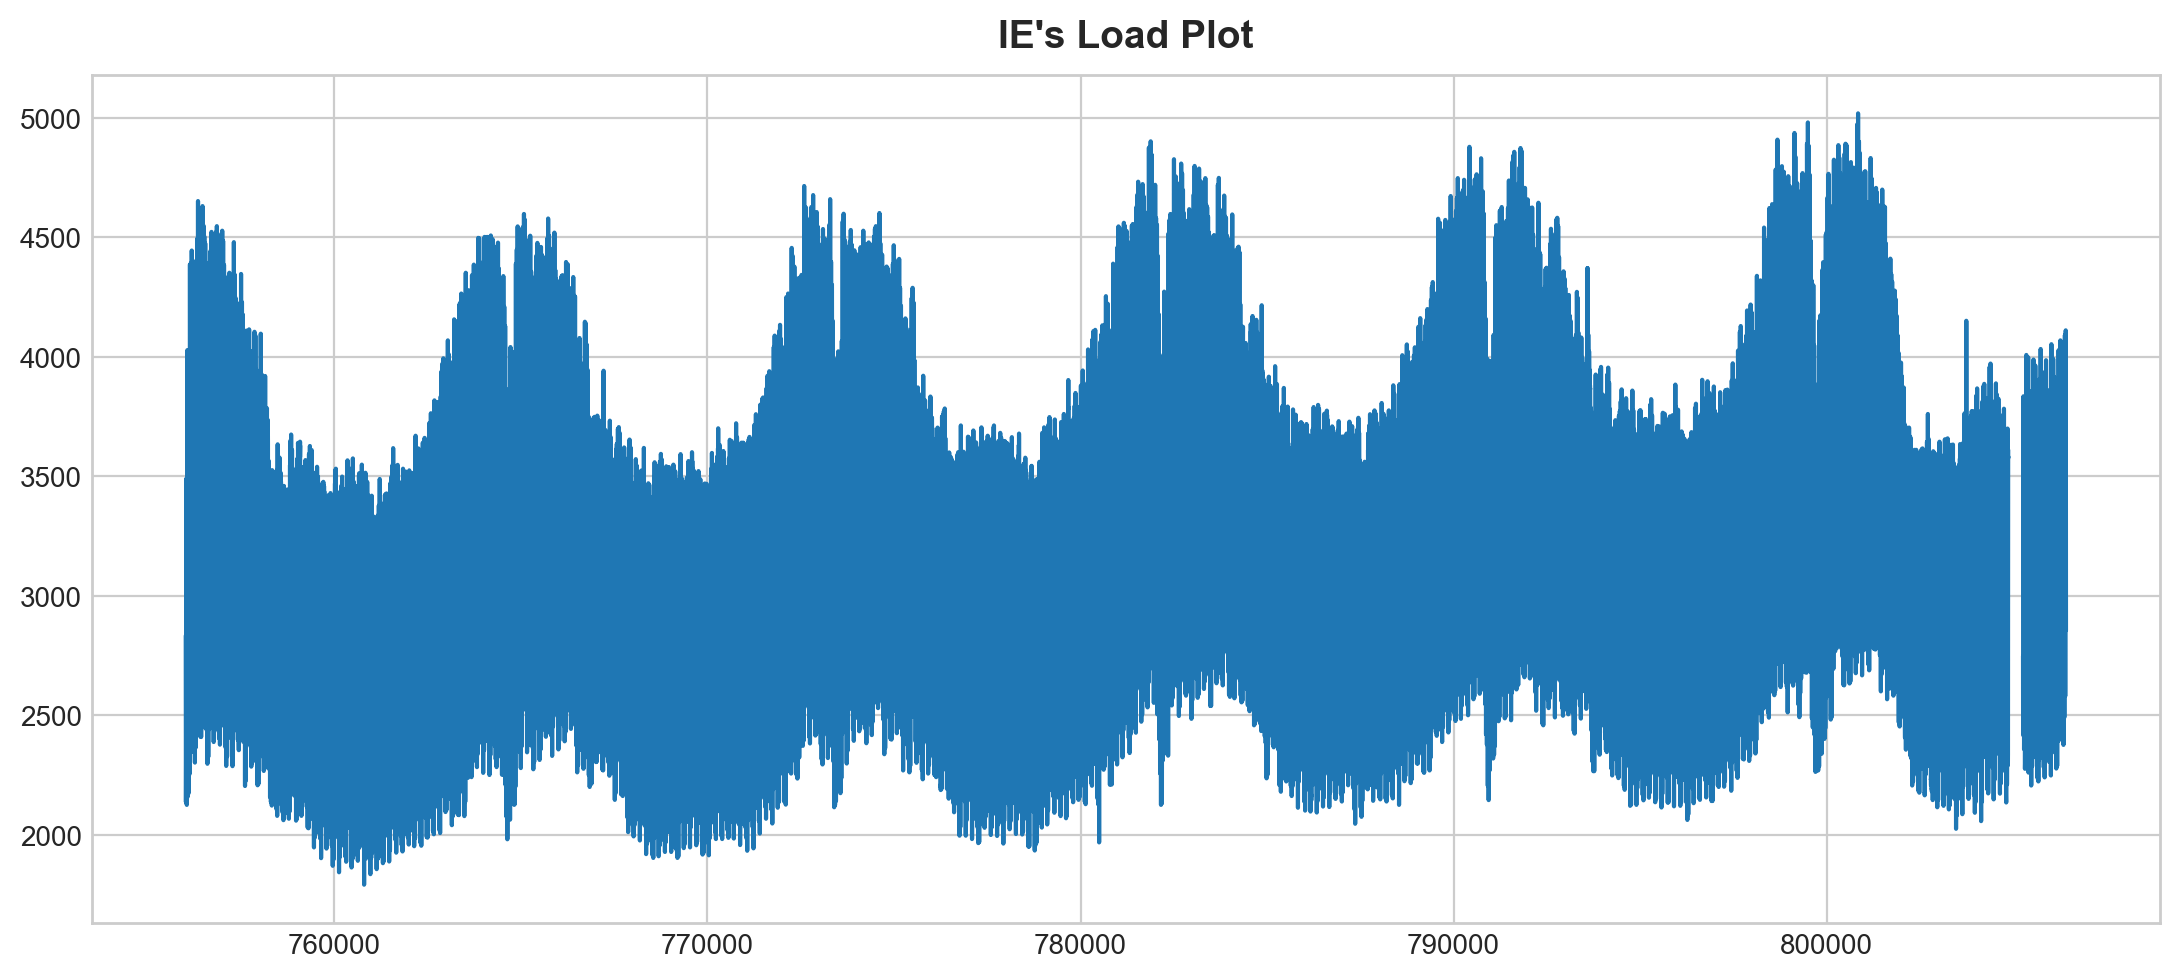

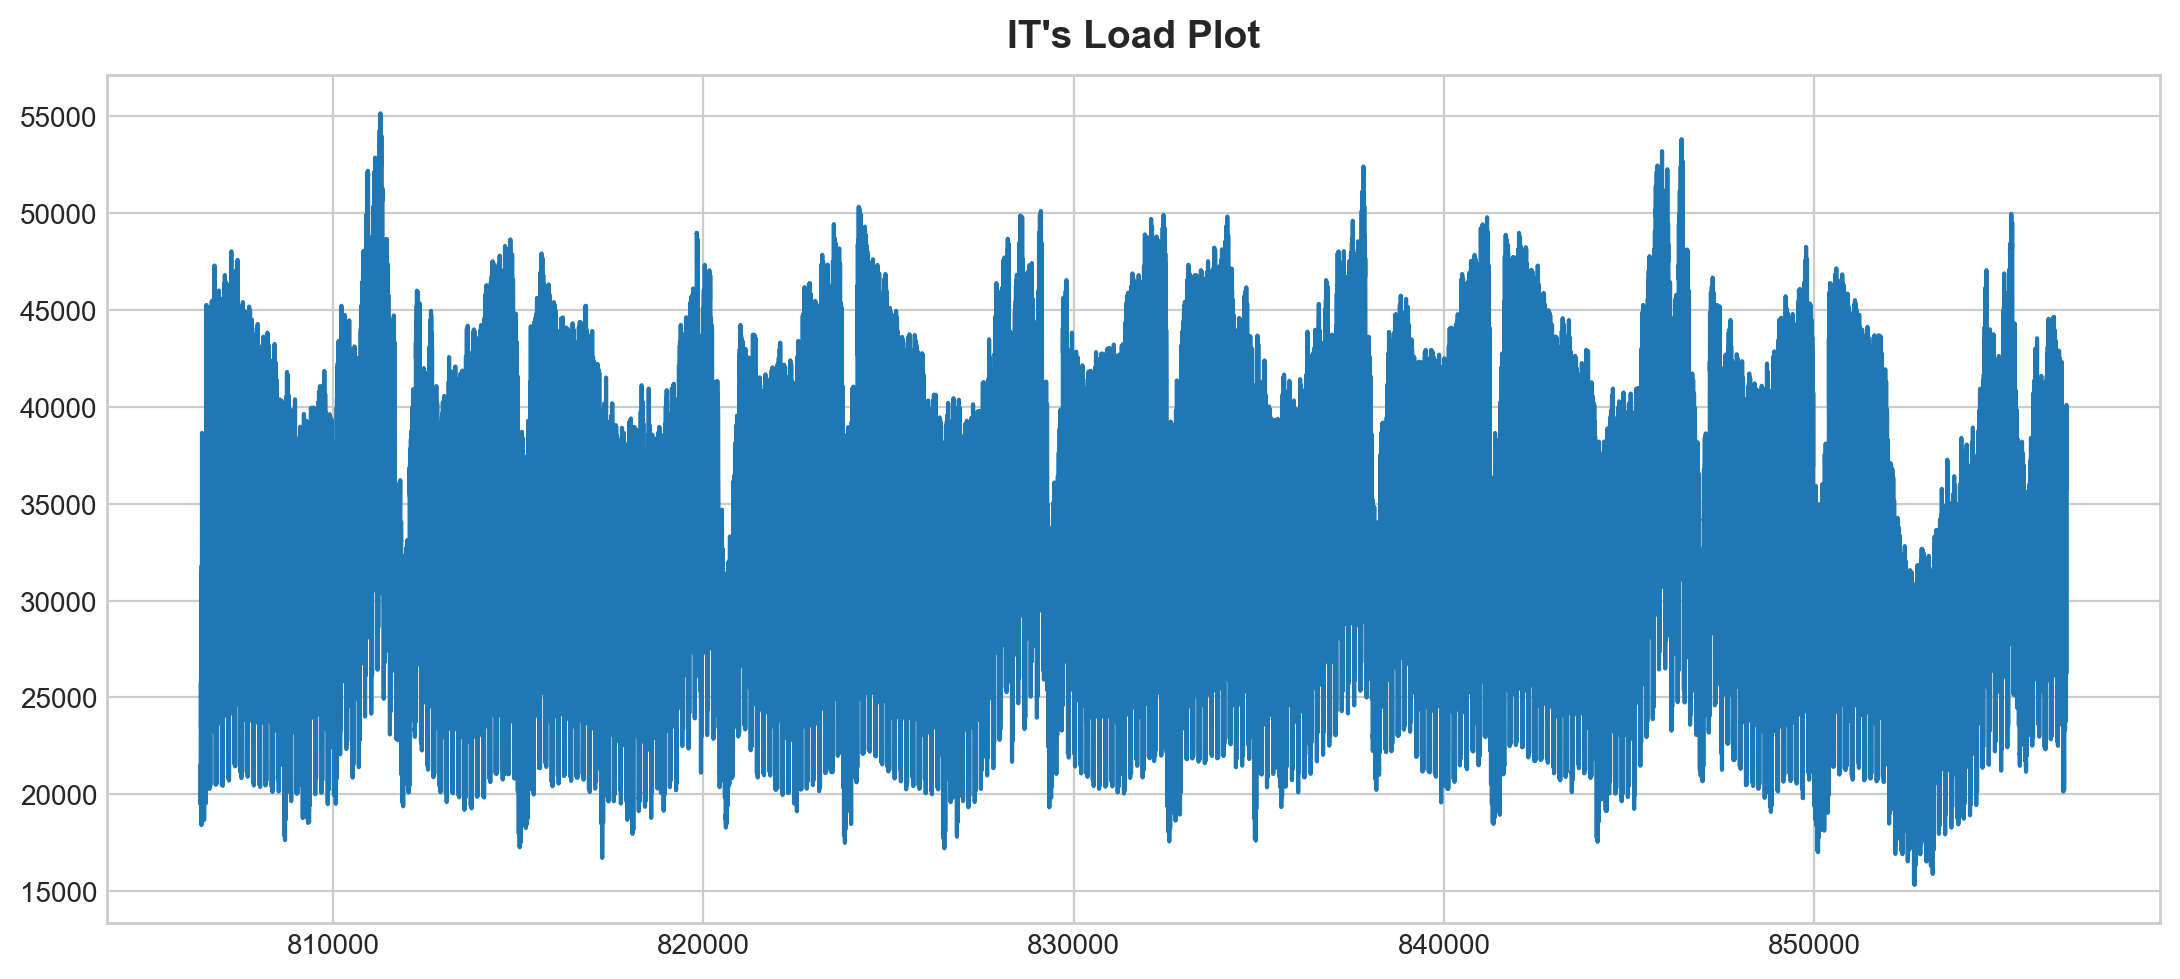

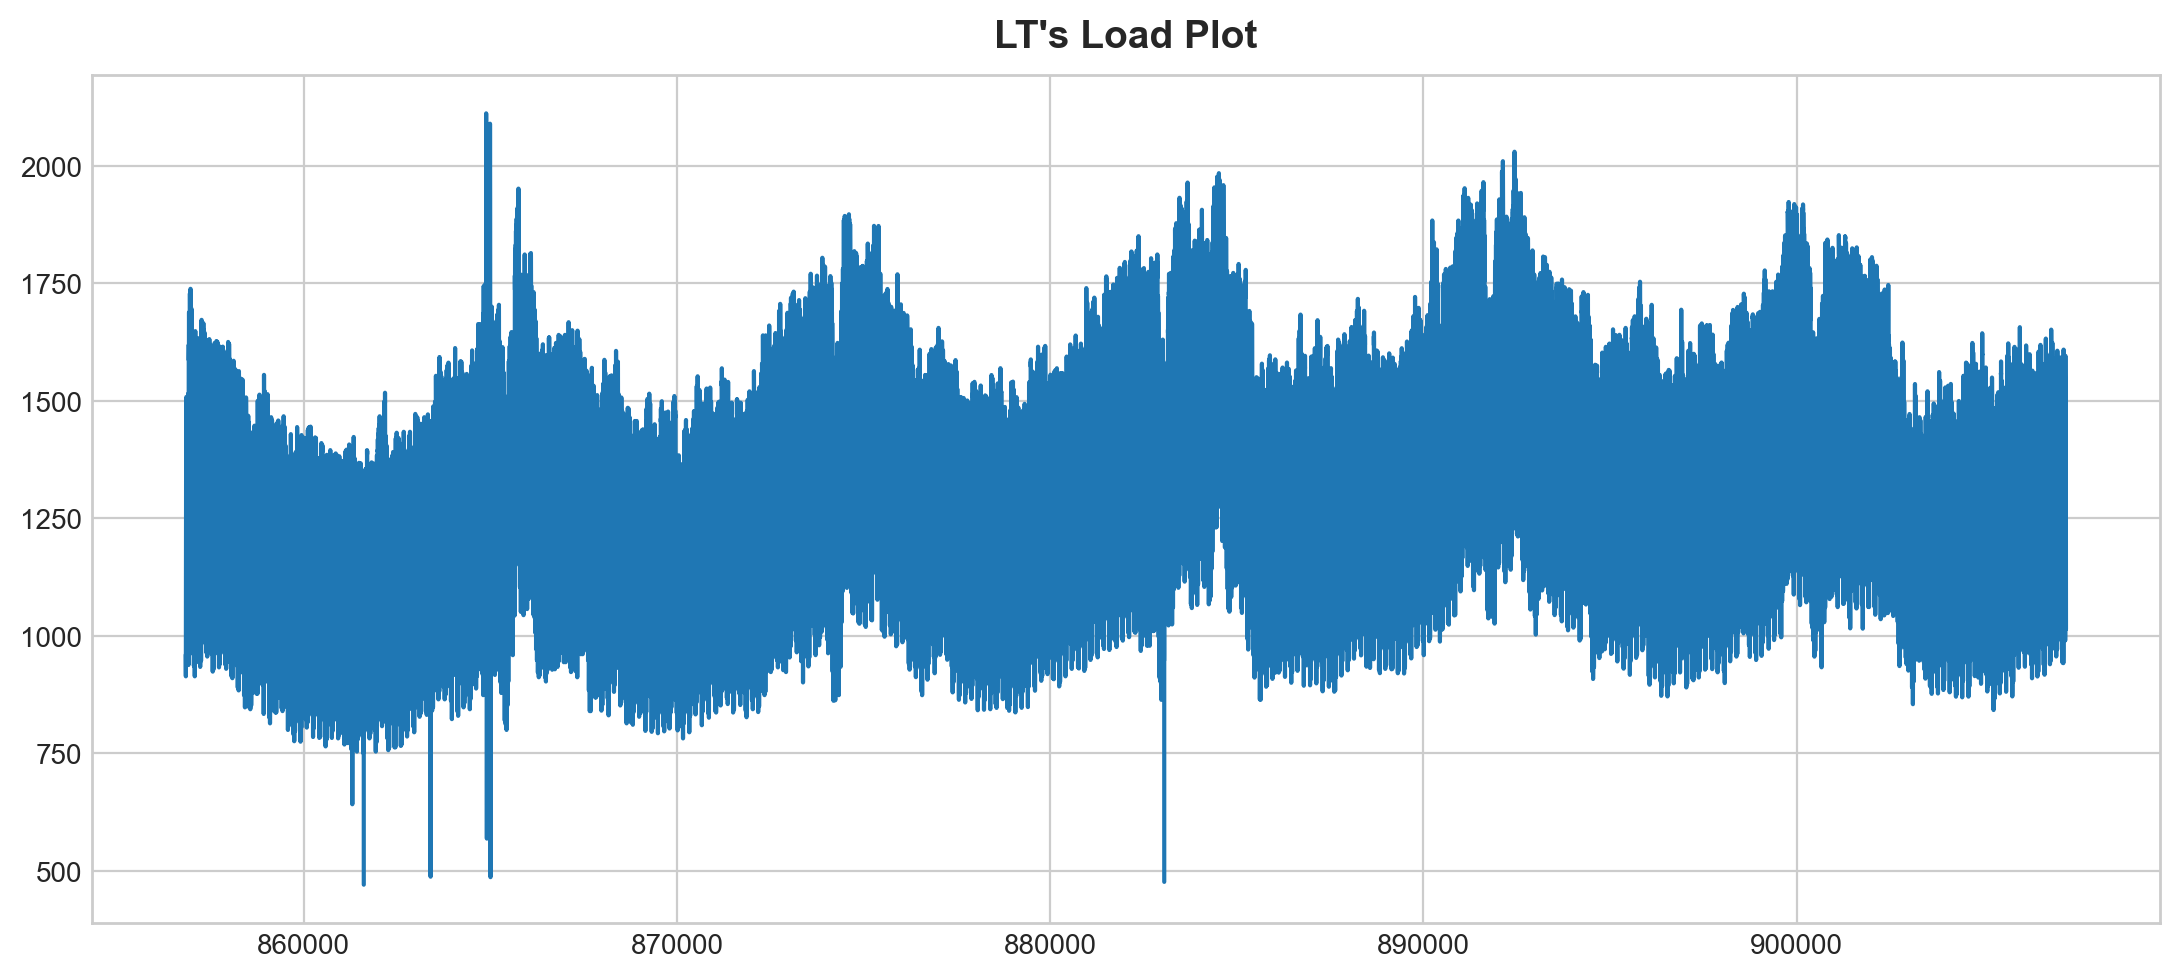

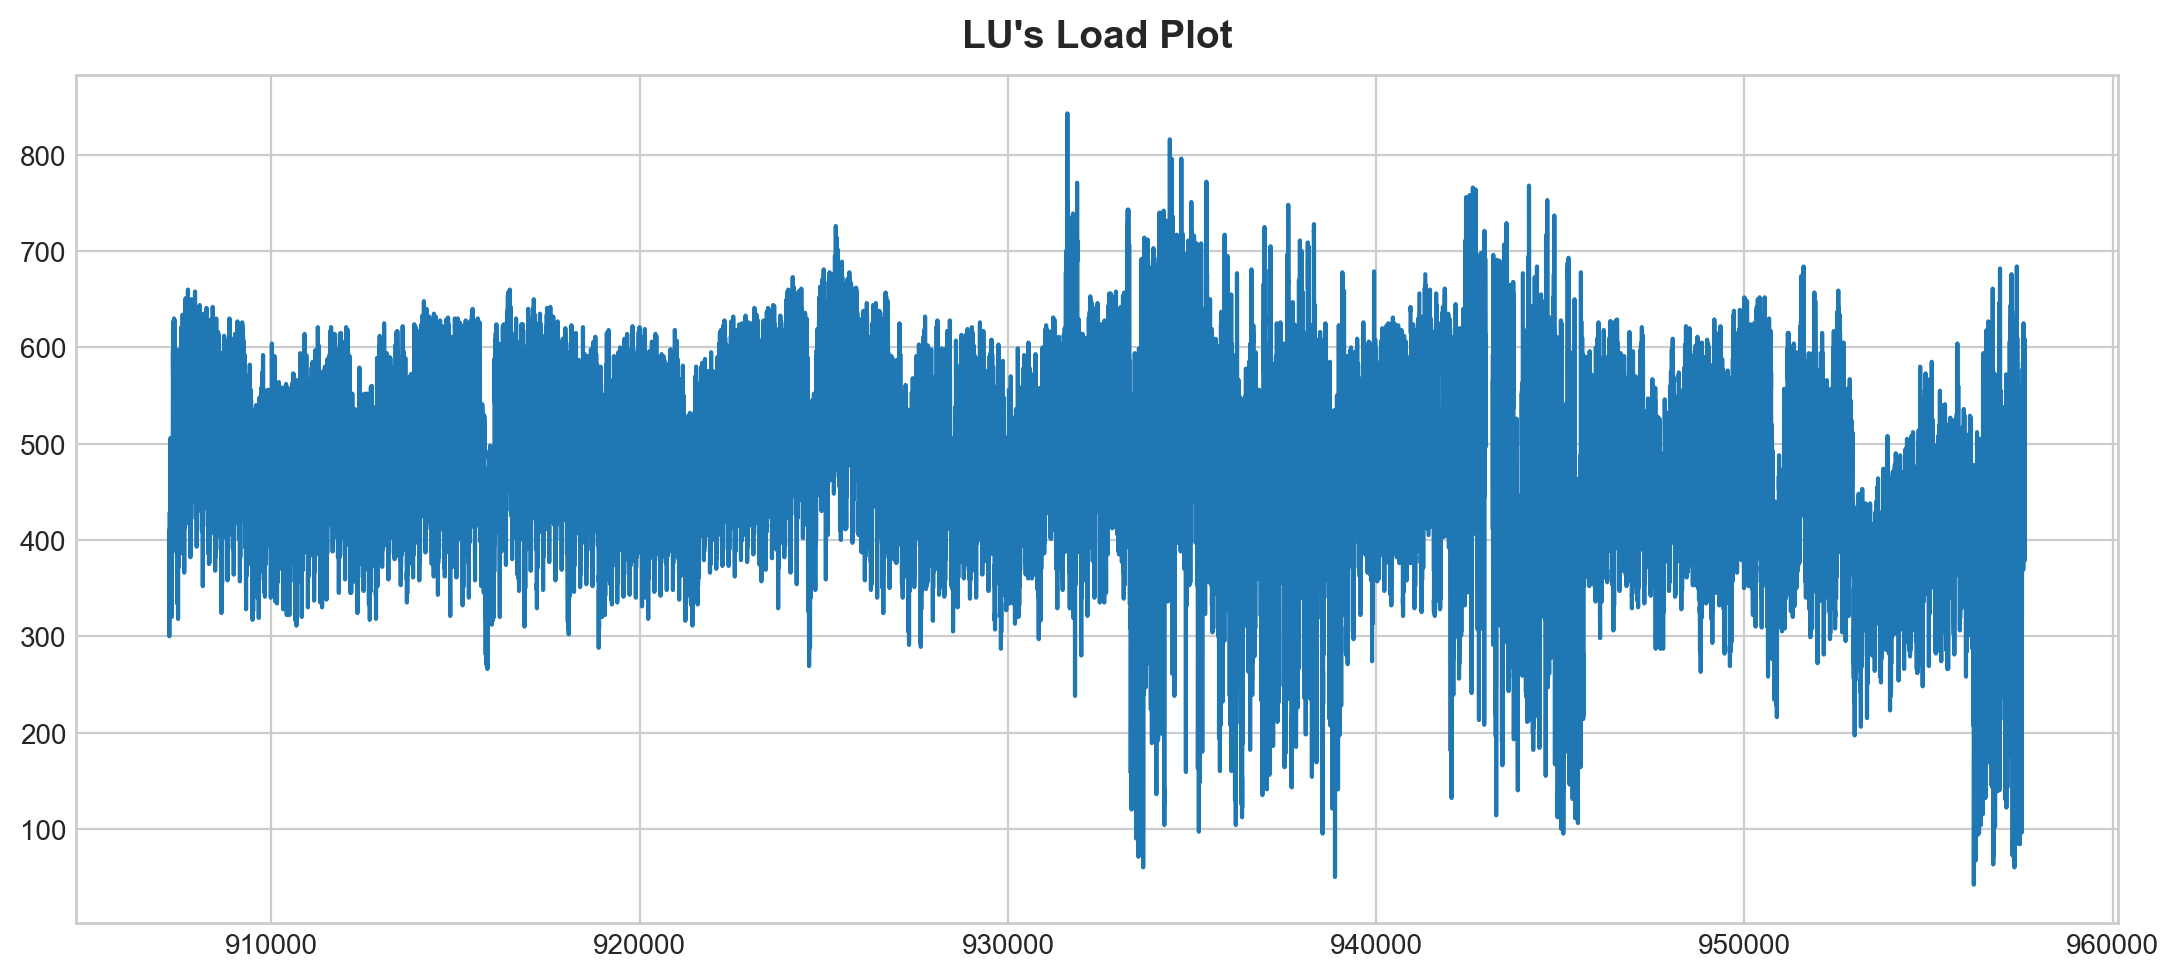

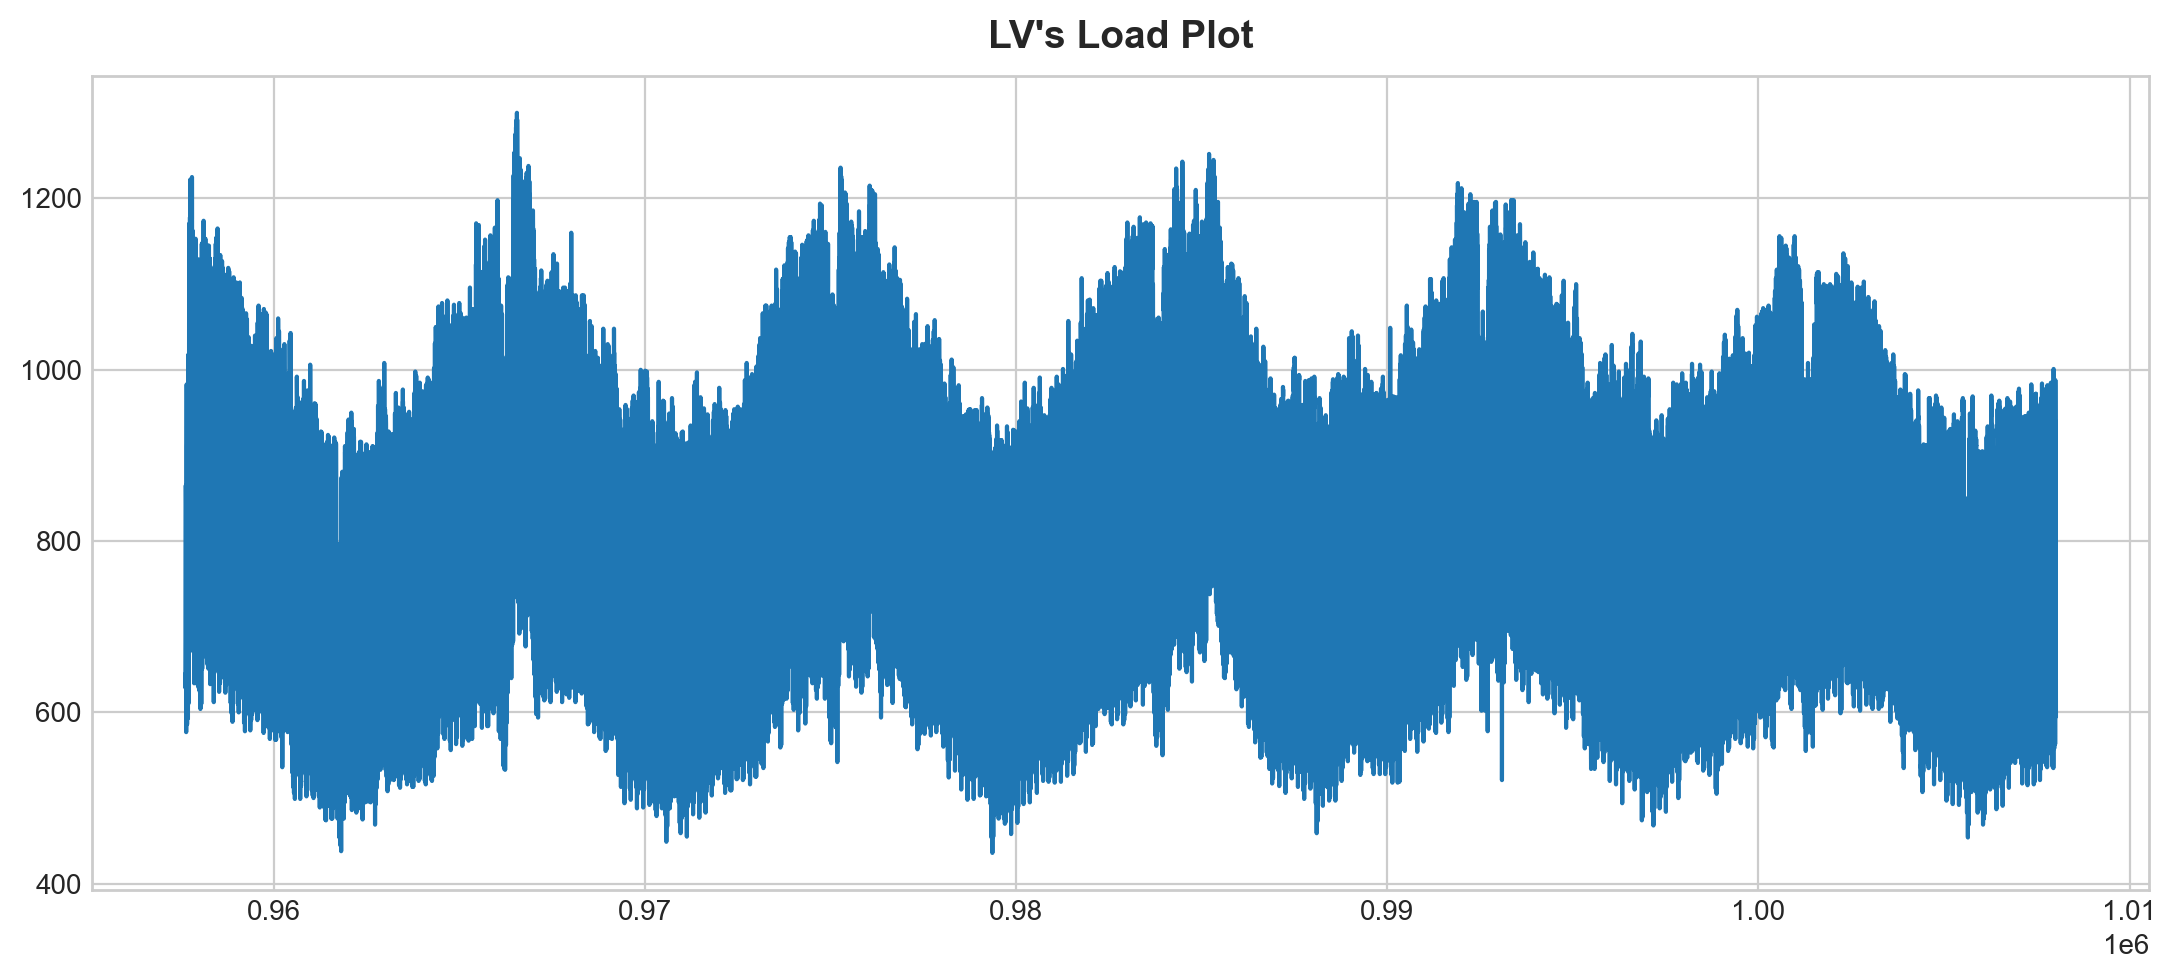

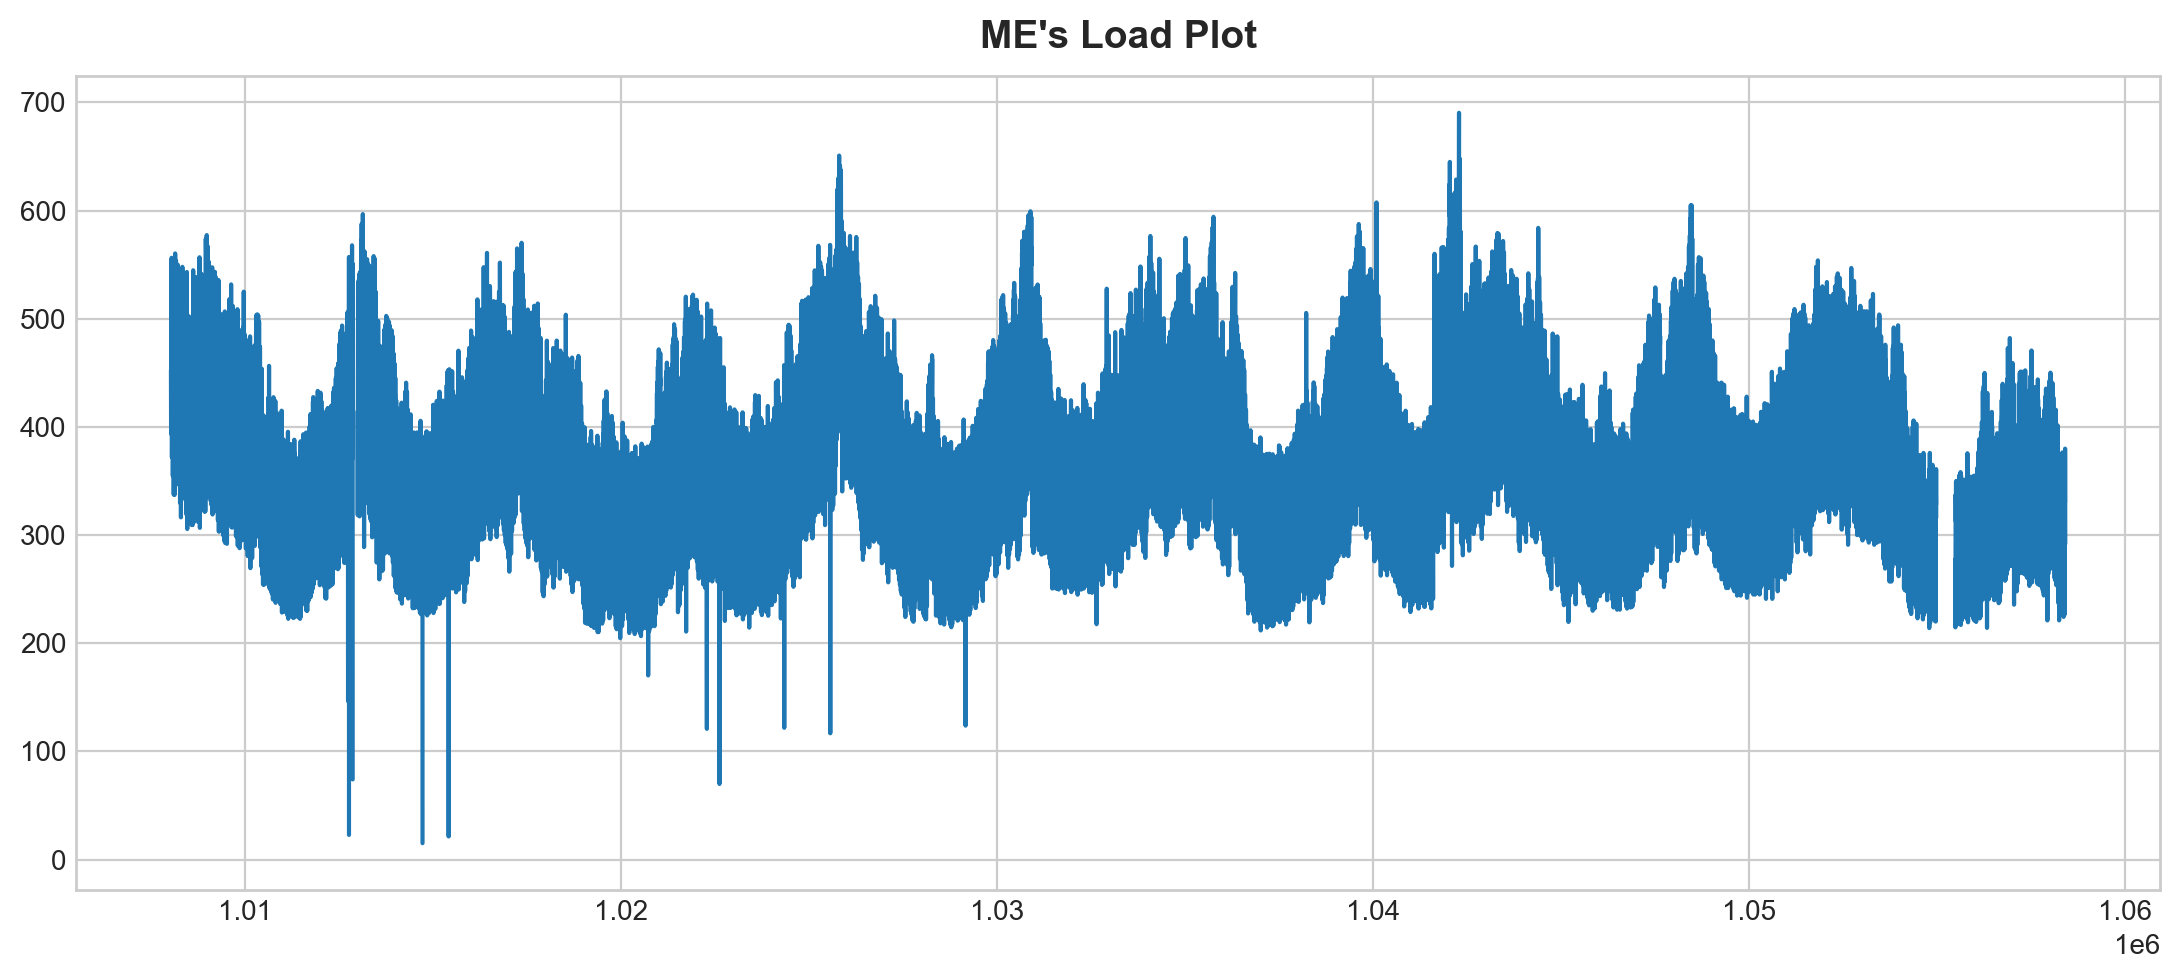

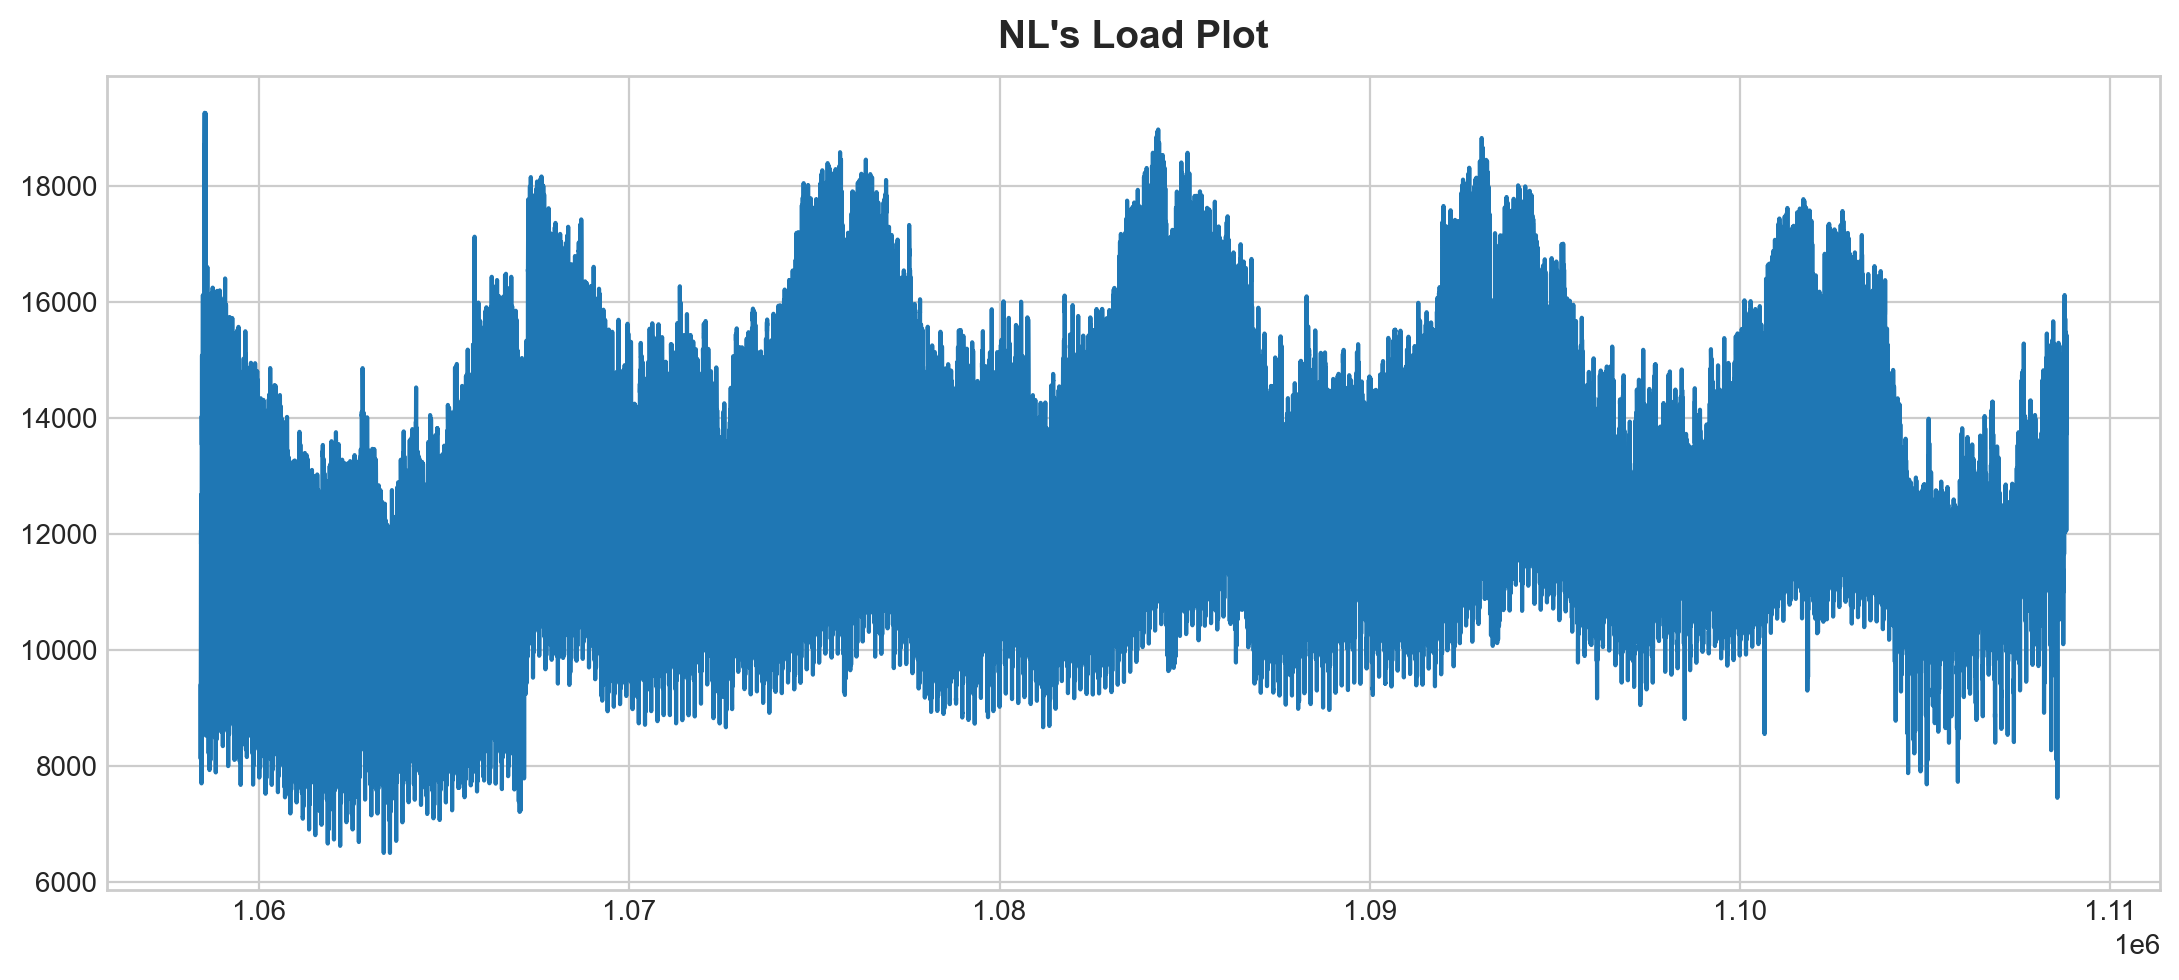

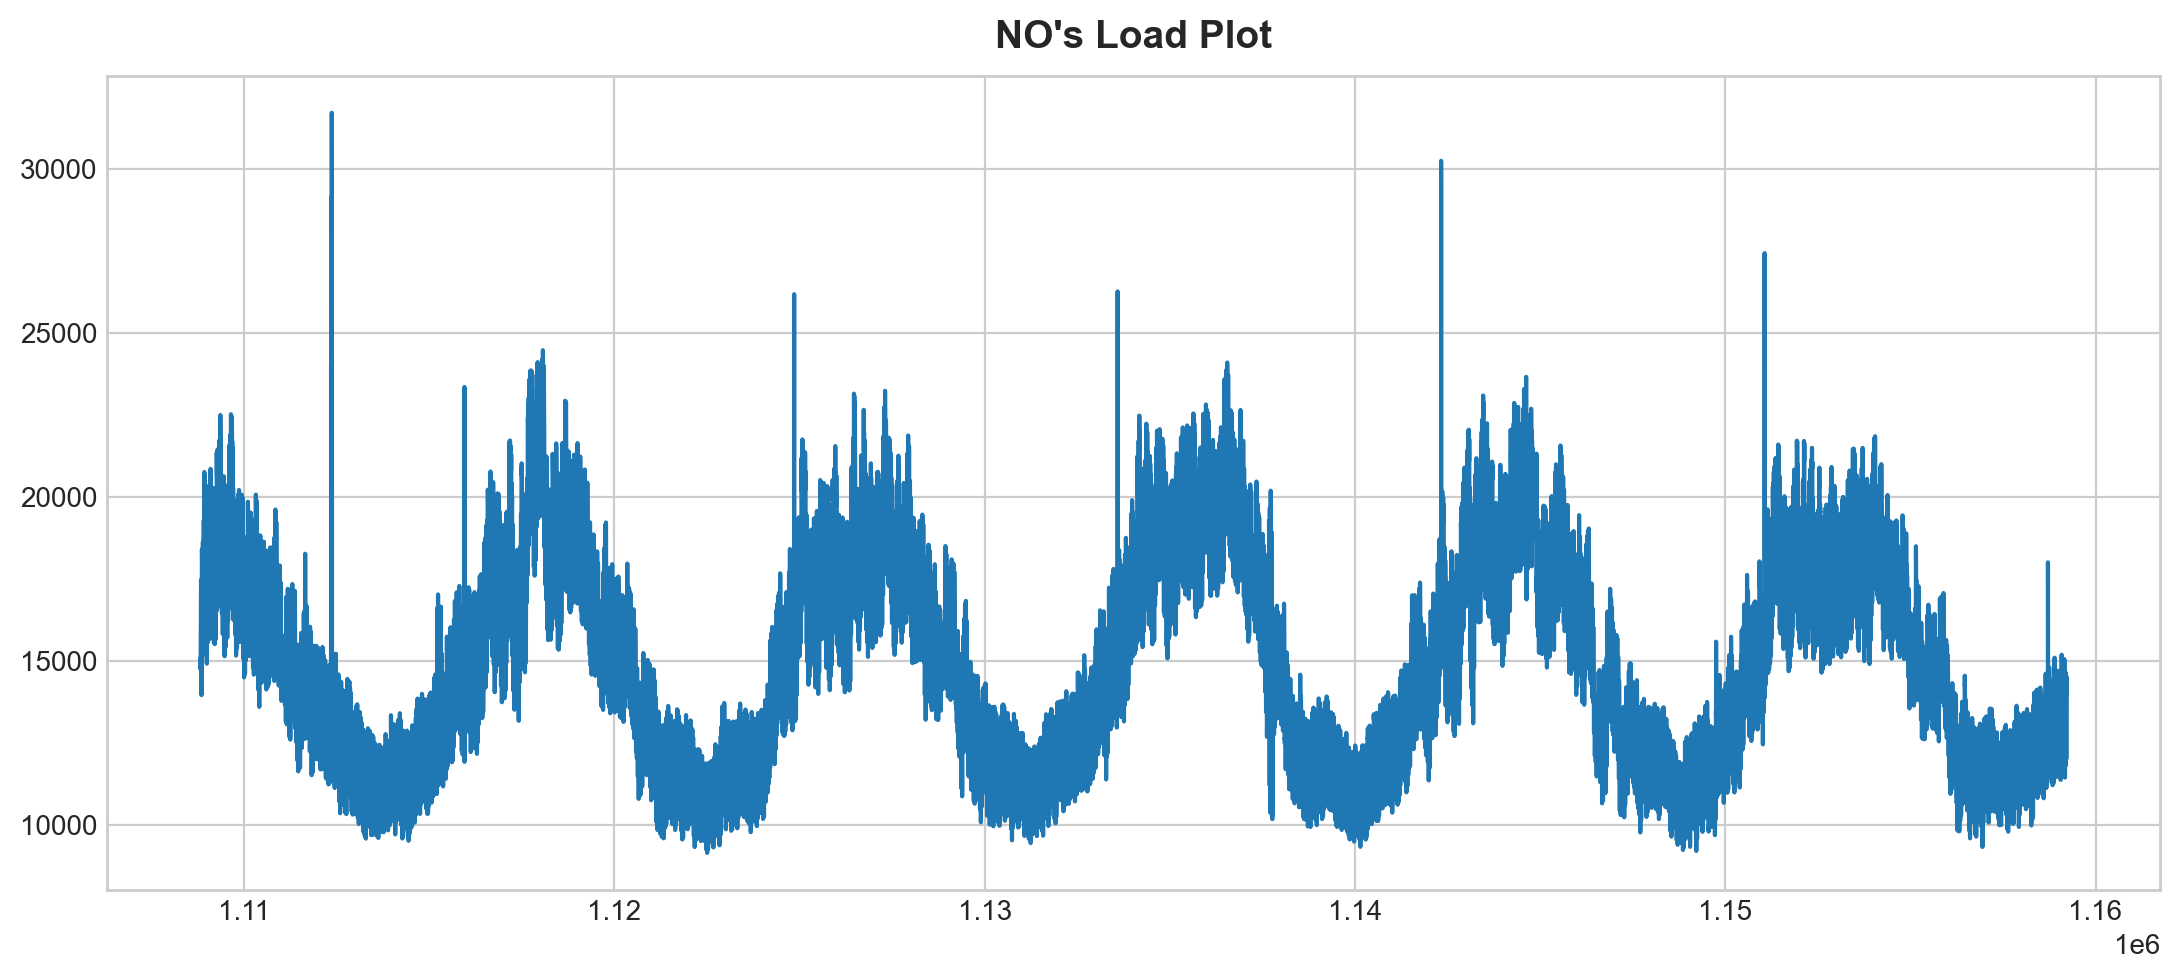

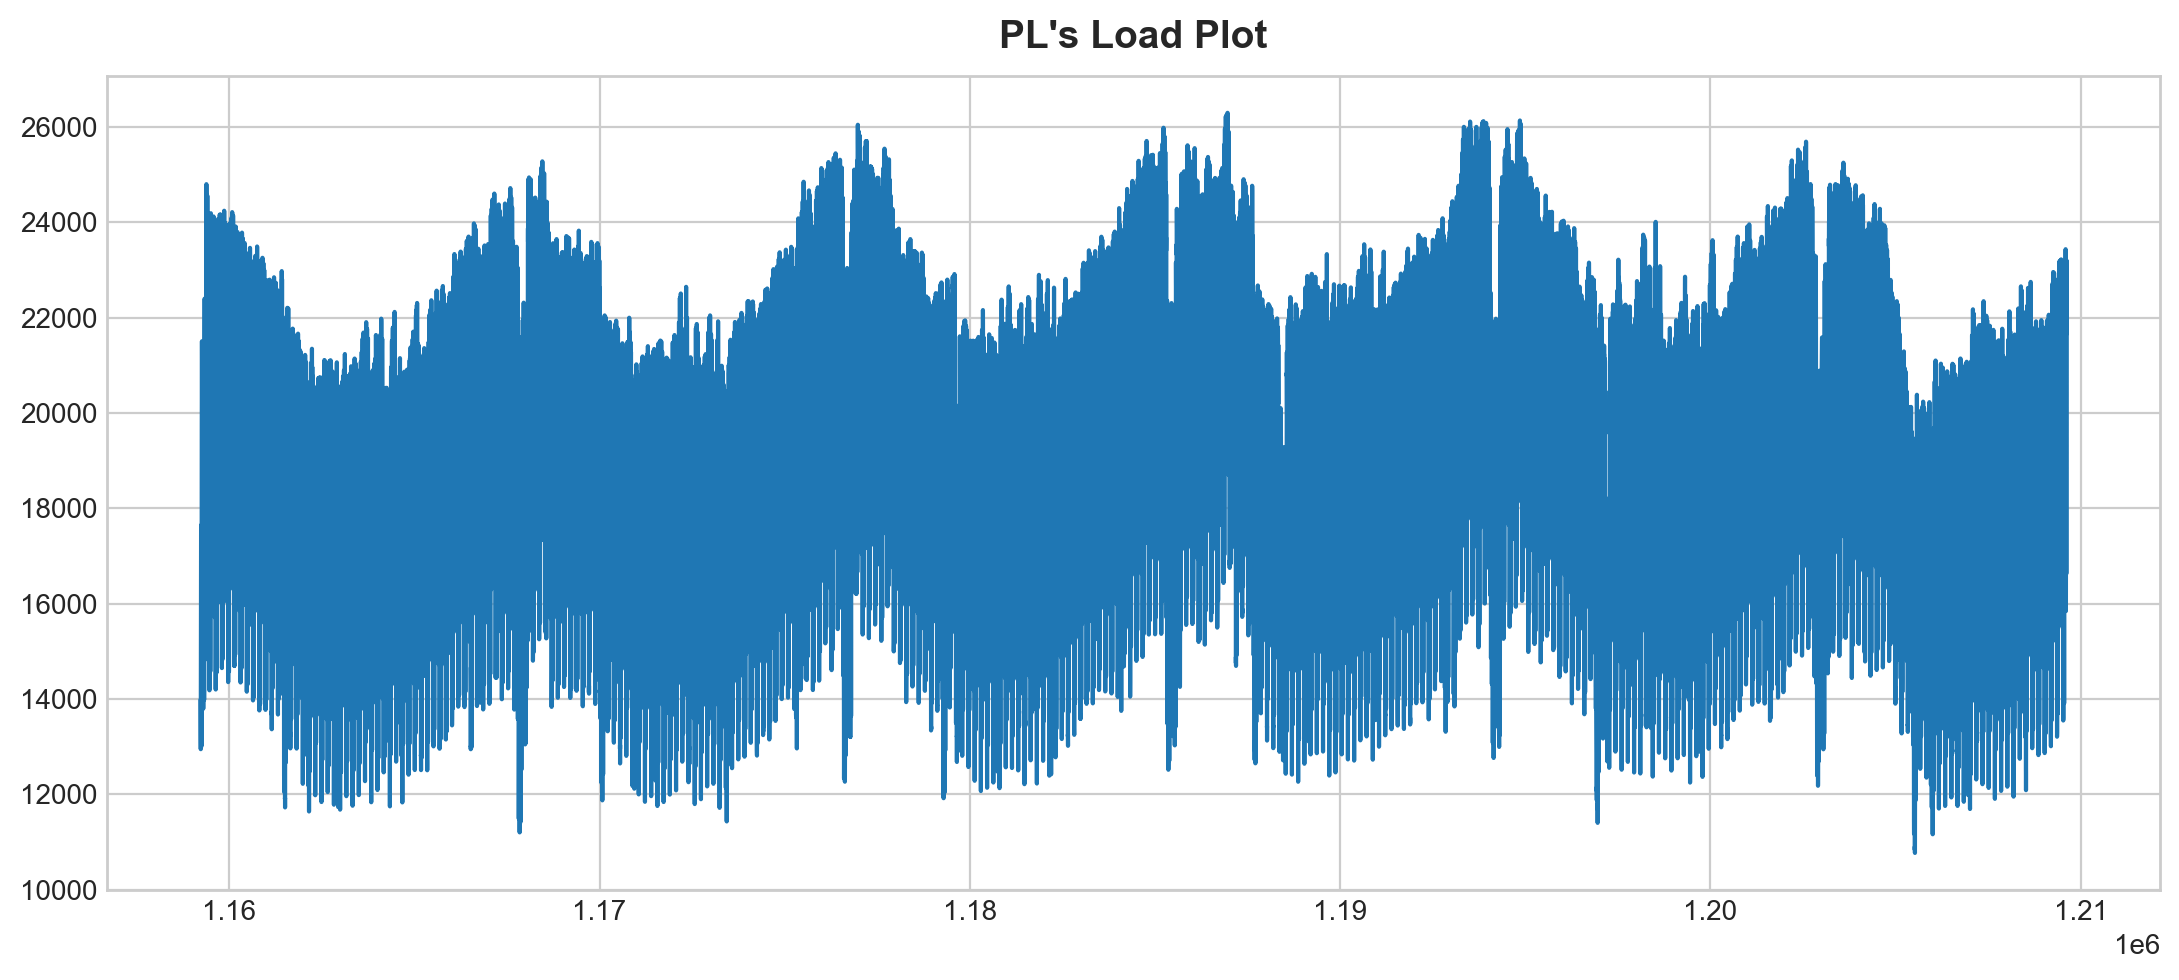

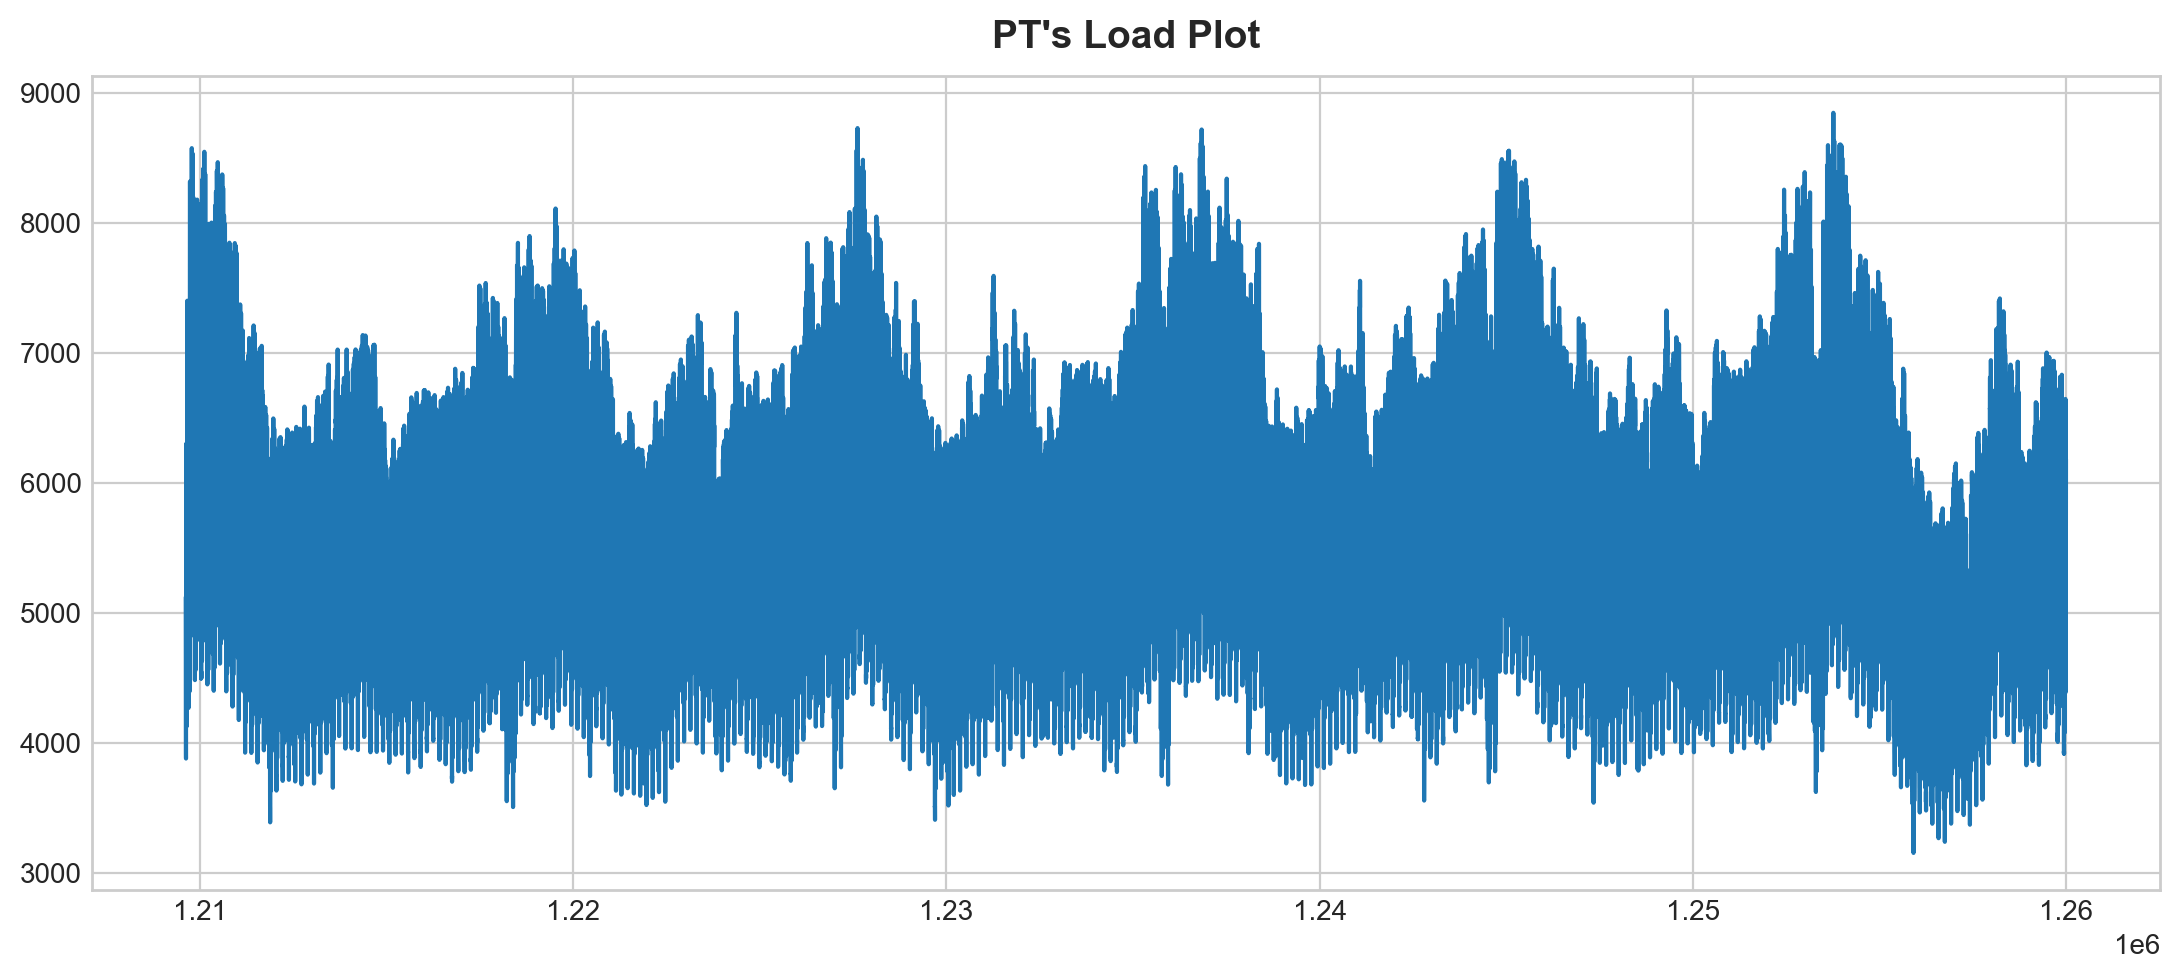

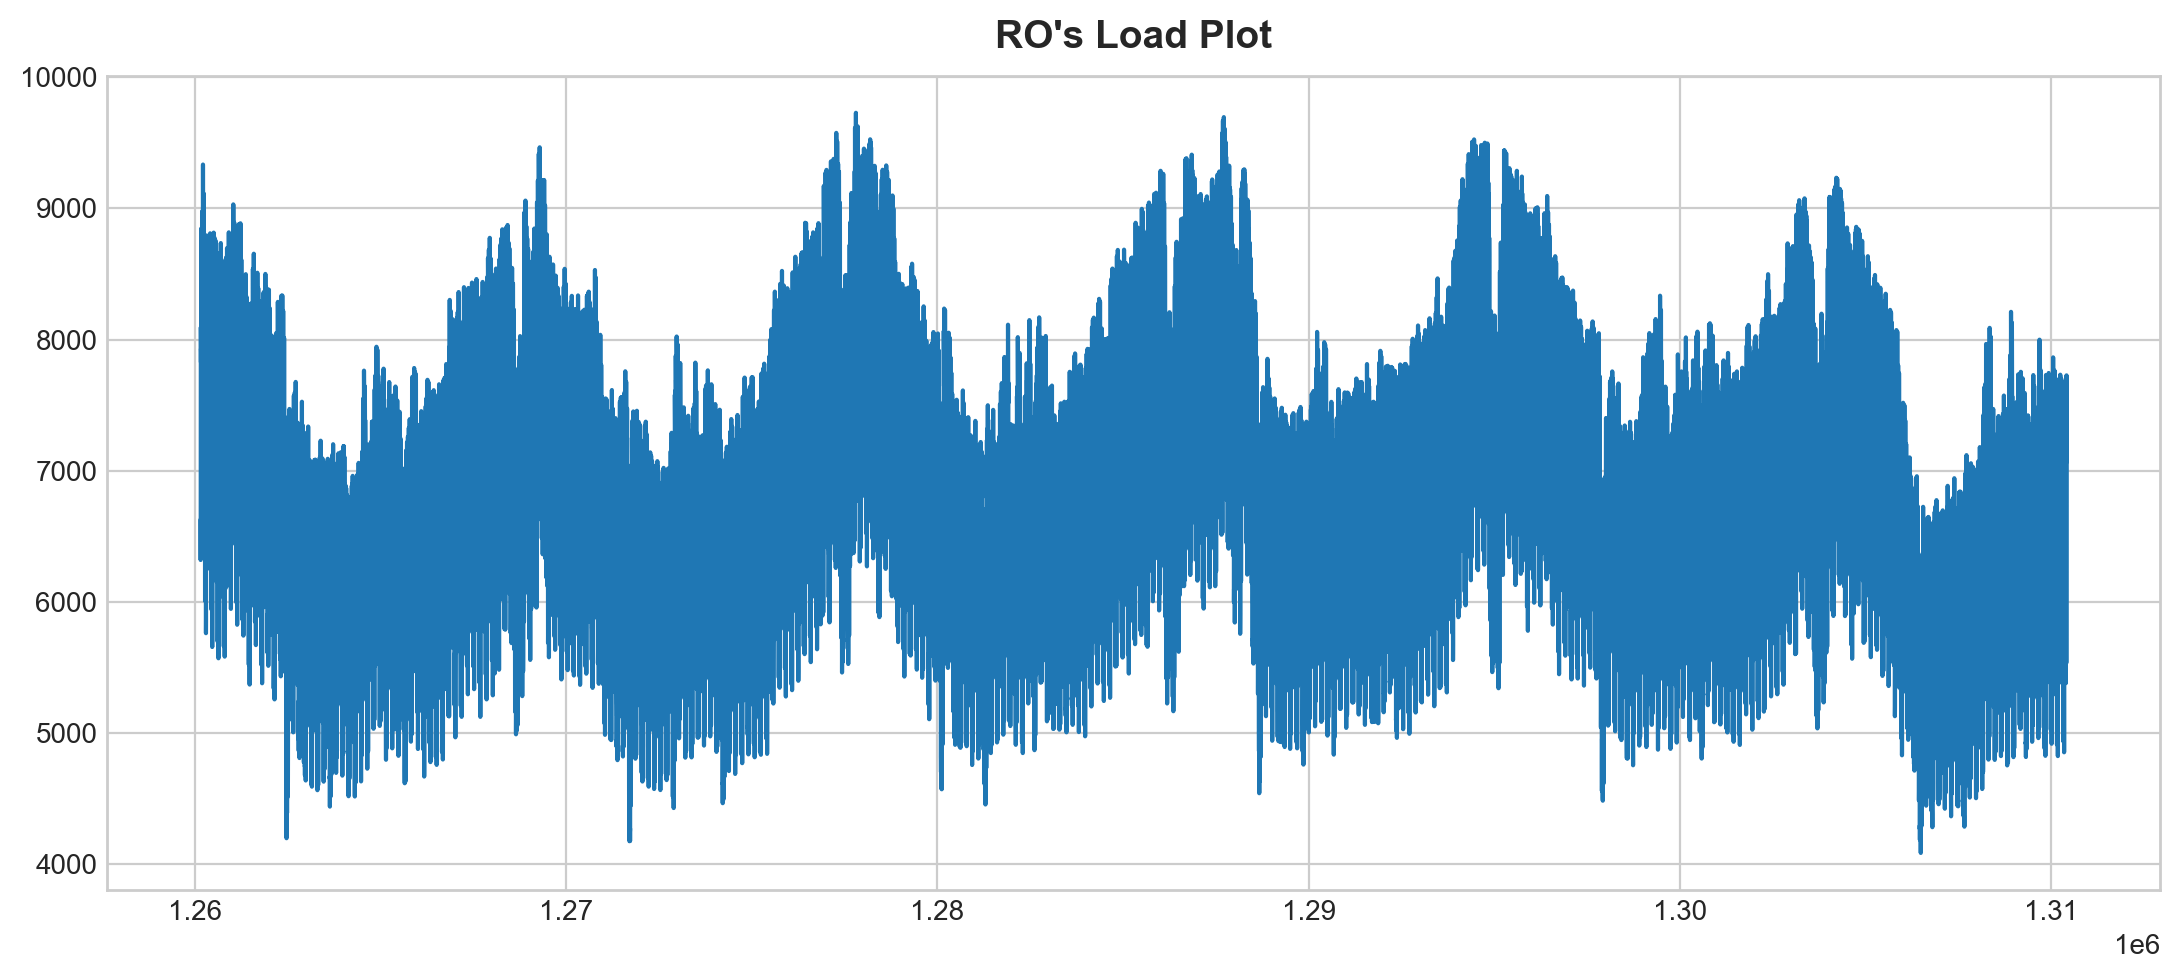

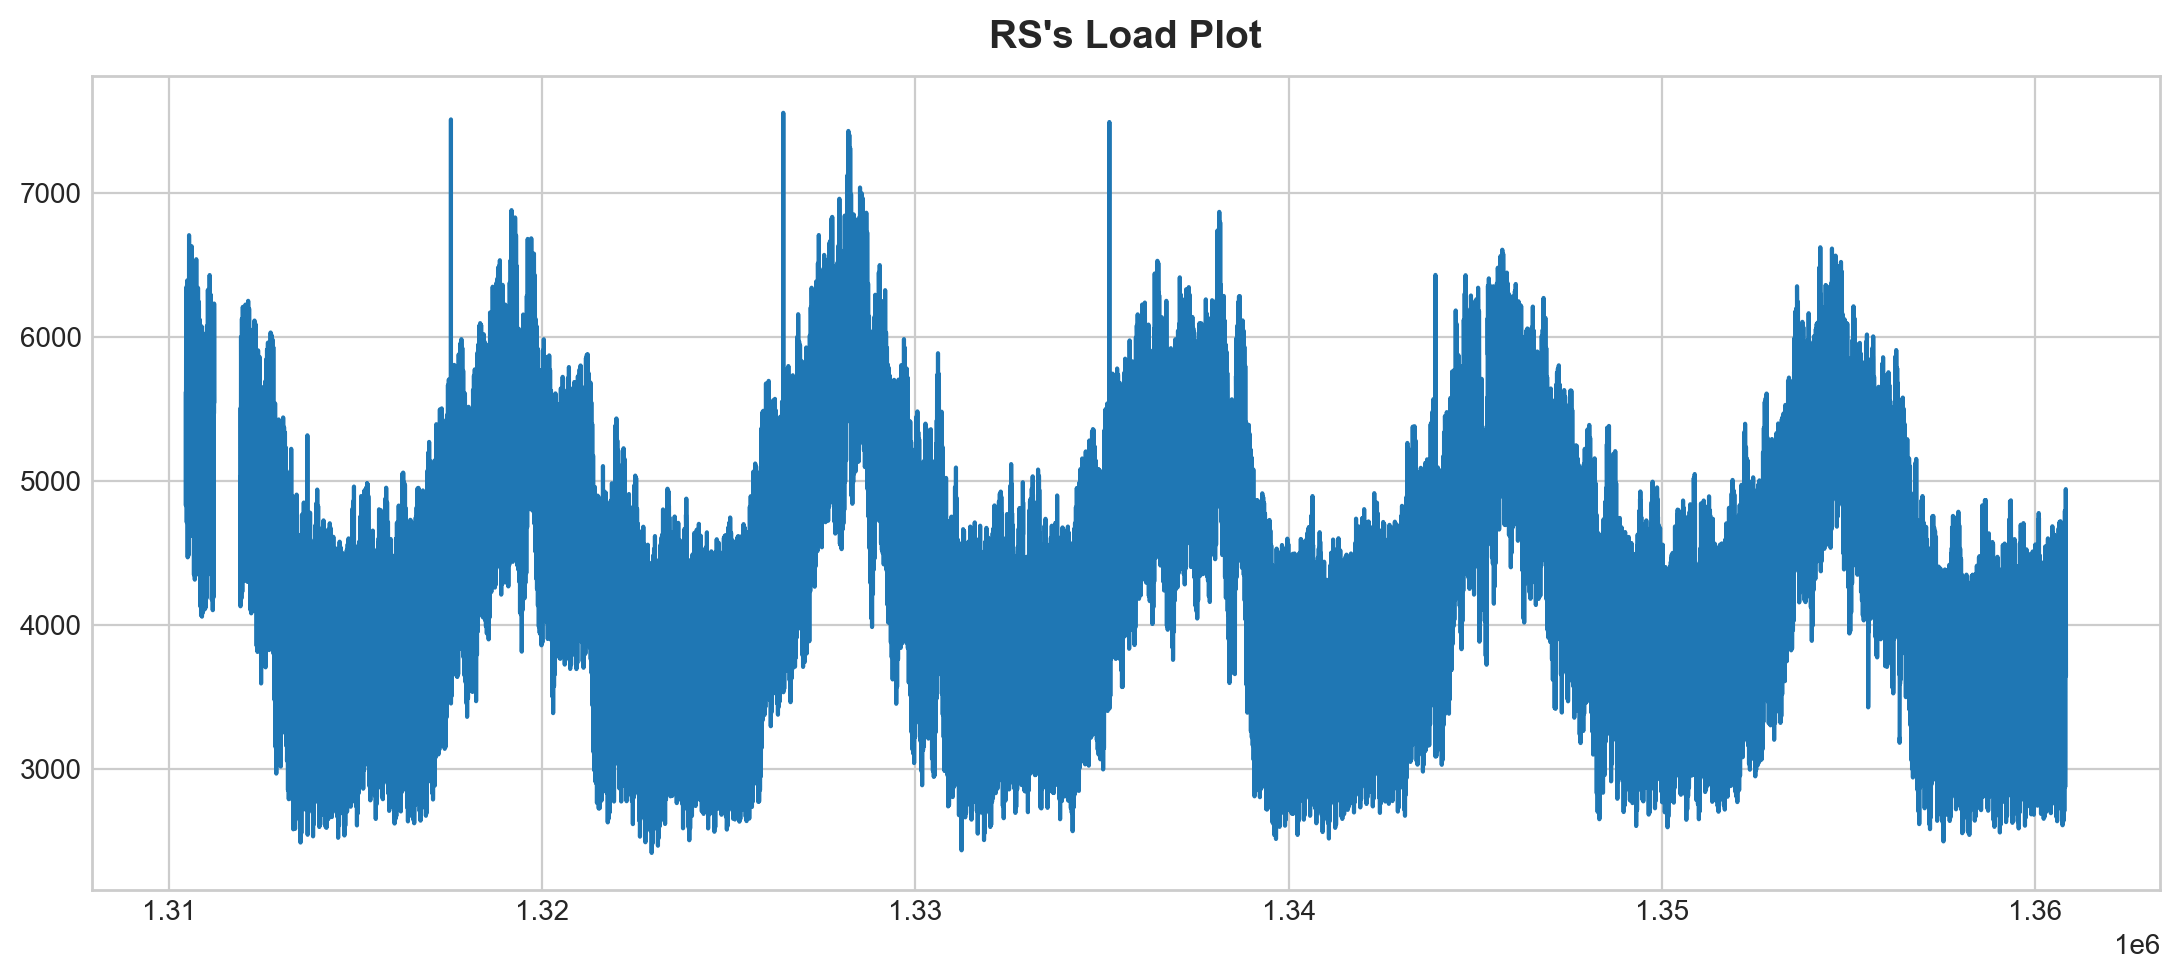

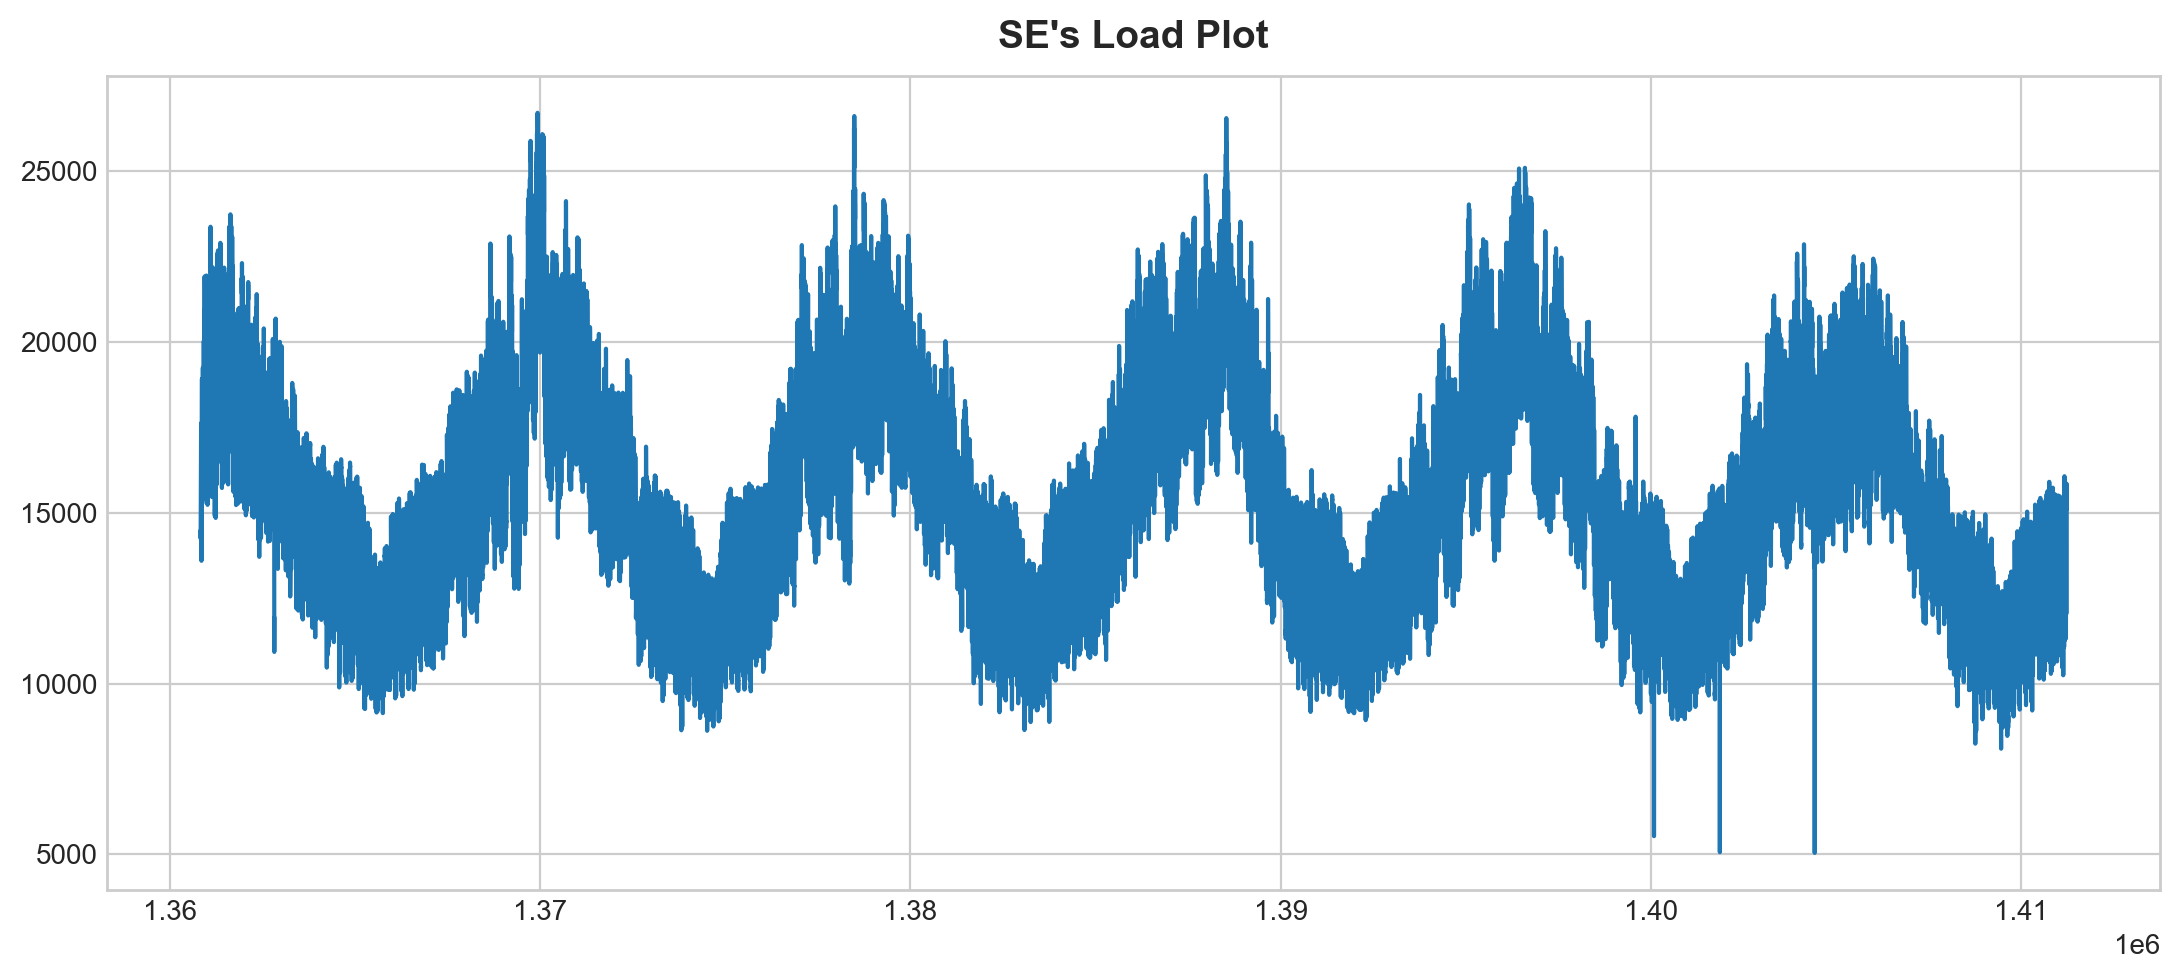

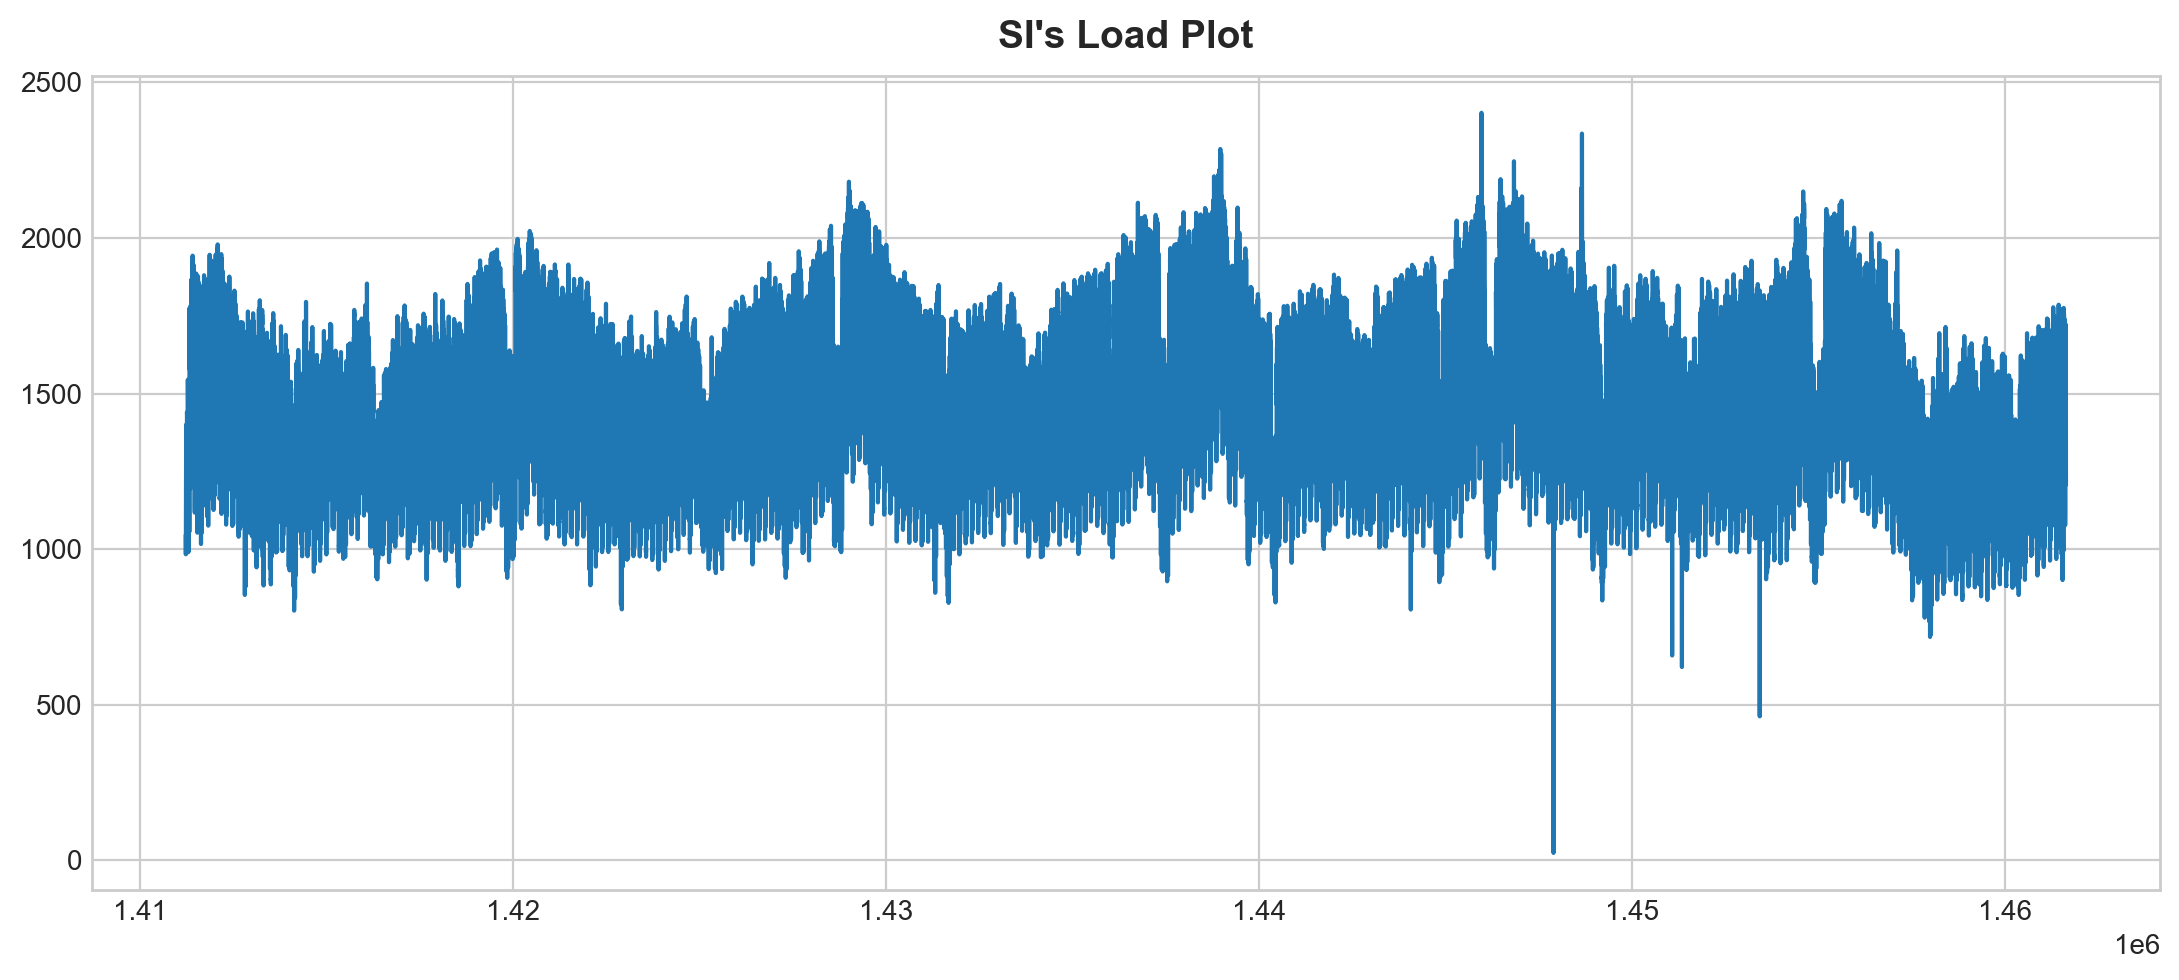

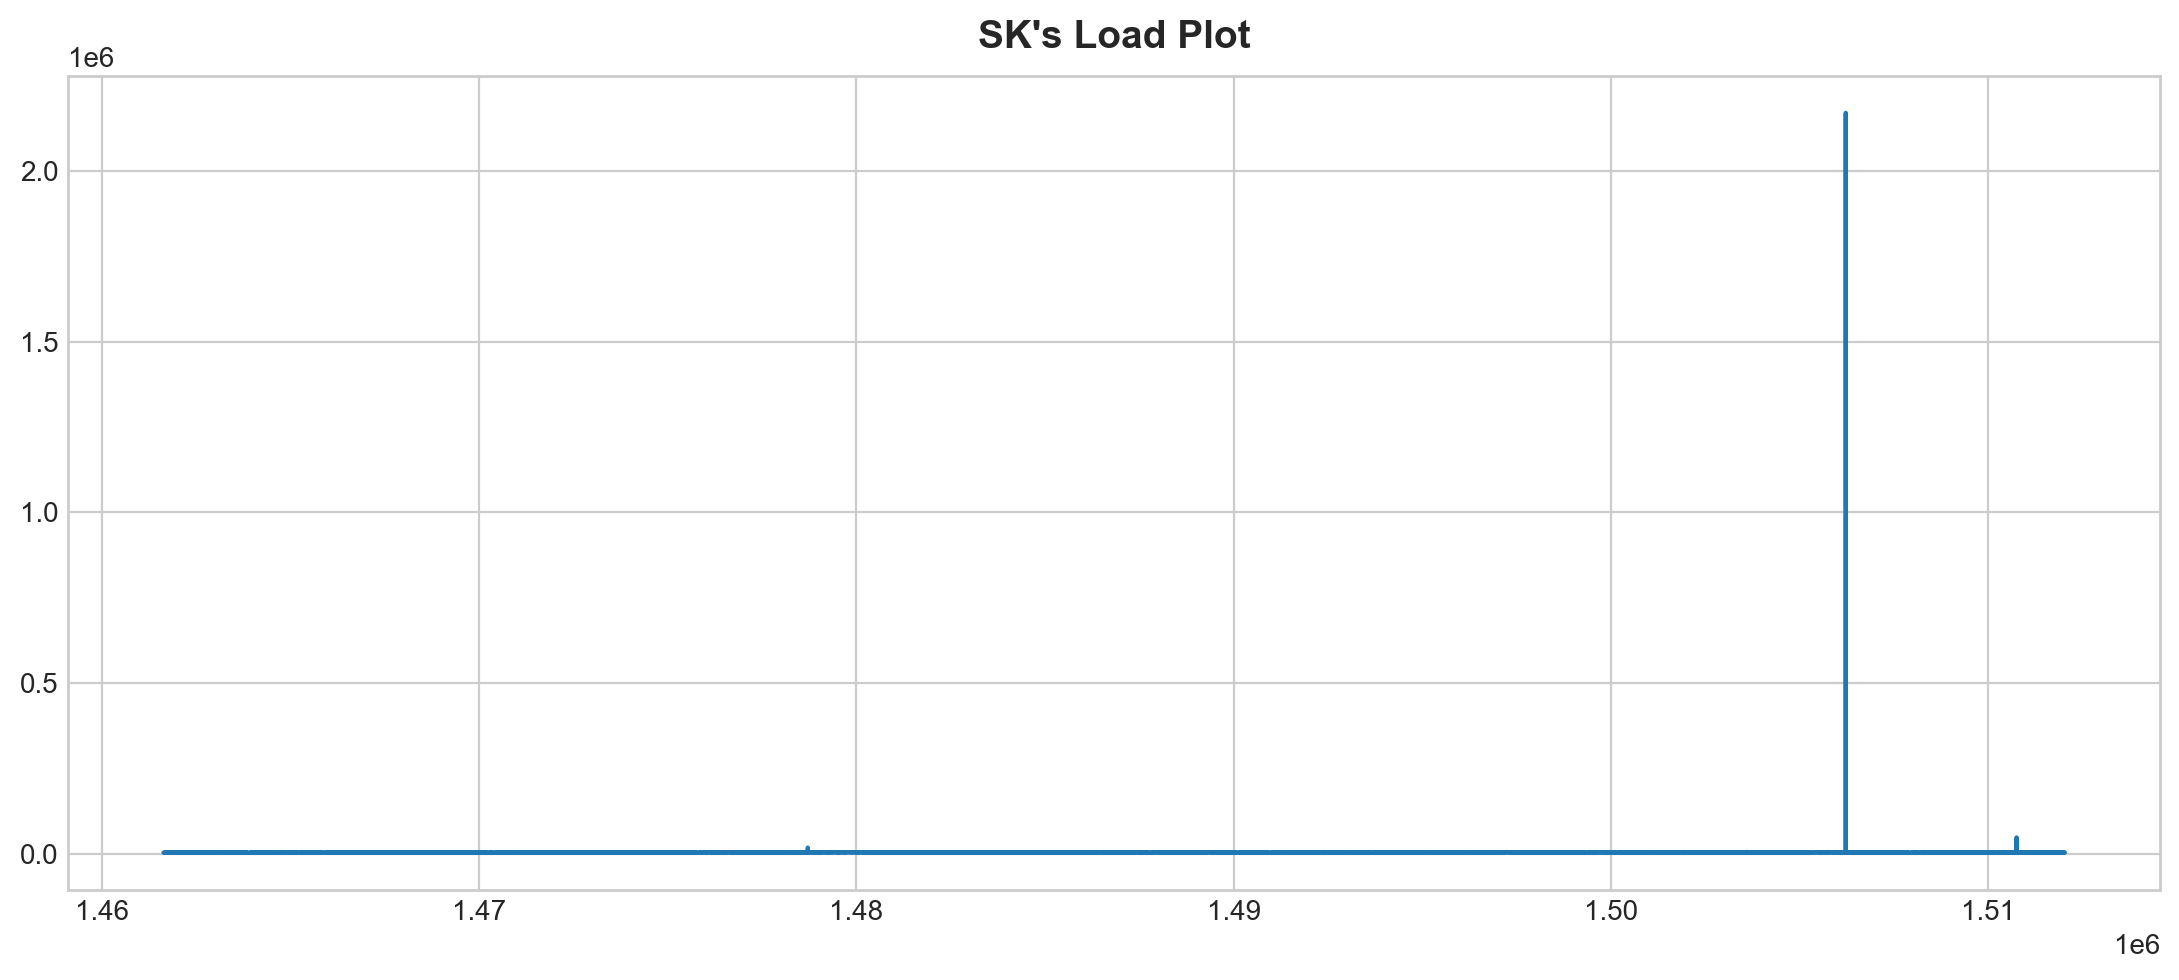

In [31]:
for cont in load_series_df.country.unique():
    plt.figure()
    load_series_df[load_series_df.country==cont].load_actual.plot(title='{}\'s Load Plot'.format(cont))

In [40]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [47]:
load_series_df['load_actual'] = load_series_df['load_actual'].dropna()
plot_periodogram(load_series_df[load_series_df.country=='AT'].load_actual)

C:\Users\as comp\AppData\Local\Temp\ipykernel_14376\4224406182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load_series_df['load_actual'] = load_series_df['load_actual'].dropna()


ValueError: array must not contain infs or NaNs